In [1]:
#!pip install unidecode numpy cython

In [2]:
#!pip install -U biogeme

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

In [4]:
# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 12)

In [5]:
pandas = pd.read_table("http://transp-or.epfl.ch/data/swissmetro.dat")

In [6]:
age_dic = {1: 'age≤24', 2: '24<age≤39', 3: '39<age≤54', 4: '54<age≤65', 5: '65<age', 6: 'not known'}
purpose_dic = {1: 'Commuter', 2: 'Shopping', 3: 'Business', 4: 'Leisure', 5: 'Return from work', 6: 'Return from shopping', 7: 'Return from business', 8: 'Return from leisure', 9: 'other'}
choice_dic = {1: 'Train', 2: 'SM', 3: 'Car'}
pandas.loc[:, ('INCOME')][(pandas['INCOME']==0)] = 1
income_dic = {1: 'under 50', 2: 'between 50 and 100', 3: 'over 100', 4: 'unknown'}
dic = [age_dic, income_dic, purpose_dic, choice_dic]
ticket_dic = {0: 'None', 1: 'Two way with half price card', 2: 'One way with half price card', 3: 'Two way normal price', 4: 'One way normal price', 5: 'Half day', 6: 'Annual season ticket', 7: 'Annual season ticket Junior or Senior', 8: 'Free travel after 7pm card', 9: 'Group ticket', 10: 'Other'}

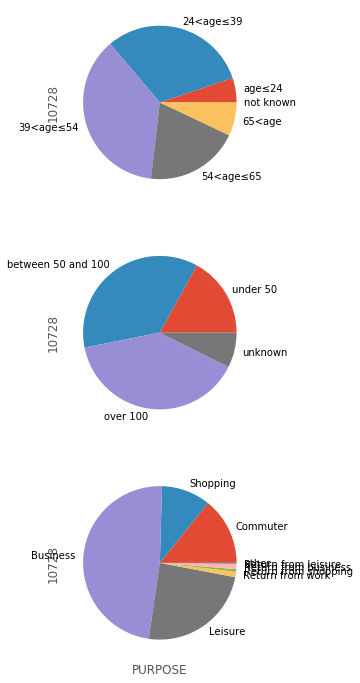

In [7]:
mkt = ['AGE', 'INCOME', 'PURPOSE']

fig, axs = plt.subplots(len(mkt))


for j,share in enumerate(mkt):
    sums = pandas['CHOICE'].groupby(pandas[share]).sum()
    axs[j].pie(sums, labels=[dic[j][i] for i in sums.index.values])
    axs[j].set(xlabel=share, ylabel=str(pandas.count()[0]))
        
for l, ax in enumerate(axs.flat):
    ax.label_outer()

In [8]:
#return from work = commuter
pandas.loc[:, ('PURPOSE')][(pandas['PURPOSE']==5)] = 1
#return from shopping = shopping
pandas.loc[:, ('PURPOSE')][(pandas['PURPOSE']==6)] = 2
#return from business = business
pandas.loc[:, ('PURPOSE')][(pandas['PURPOSE']==7)] = 3
#return from leisure = leisure
pandas.loc[:, ('PURPOSE')][(pandas['PURPOSE']==8)] = 4

In [9]:
for p in pandas['PURPOSE'].unique().tolist():
    if len(pandas['CHOICE'][(pandas['PURPOSE'] == p )&(pandas['CHOICE'] !=0 )].unique().tolist()) == 3:
        print(purpose_dic[p]+' is relevant '+ str(p))

Commuter is relevant 1
Shopping is relevant 2
Business is relevant 3
Leisure is relevant 4


In [10]:
pandas = pandas[(pandas['AGE'] !=6 ) & \
                #(pandas['INCOME'] !=4 ) &\
                (pandas['PURPOSE'] !=9 ) &\
                (pandas['CHOICE'] !=0 )]

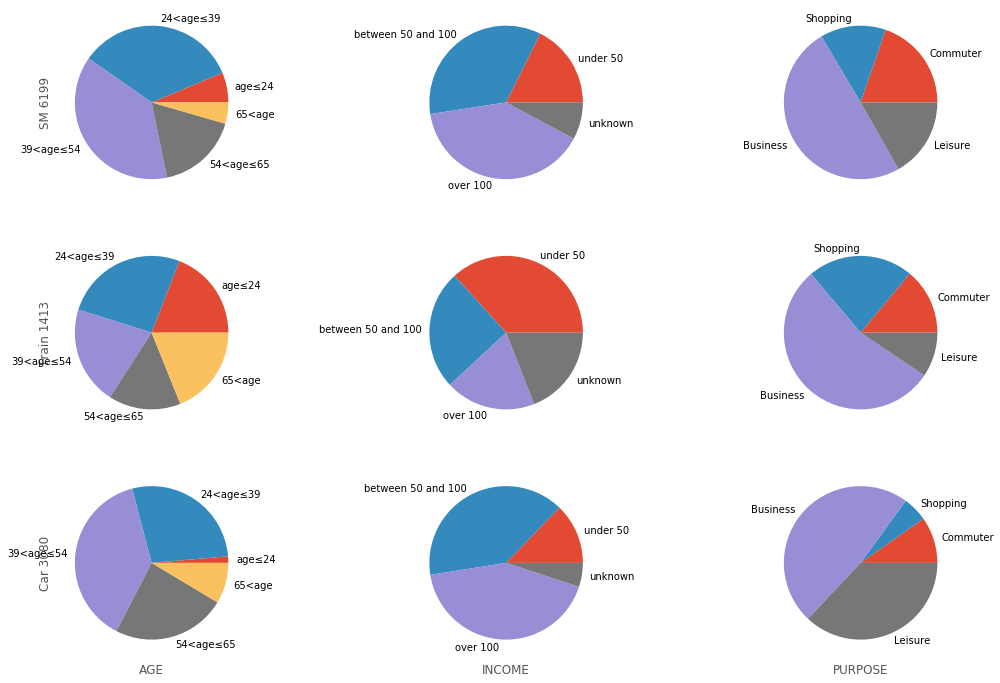

In [11]:
ch = pandas['CHOICE'].unique().tolist()
mkt = ['AGE', 'INCOME', 'PURPOSE']

fig, axs = plt.subplots(len(ch), len(mkt))

for k,c in enumerate(ch):
    for j,share in enumerate(mkt):
        sums = pandas['CHOICE'][(pandas['CHOICE']==c)].groupby(pandas[share]).sum()
        axs[k, j].pie(sums, labels=[dic[j][i] for i in sums.index.values])
        axs[k, j].set(xlabel=share, ylabel=choice_dic[c]+' '+str(pandas[(pandas['CHOICE']==c)].count()[0]))
        
for l, ax in enumerate(axs.flat):
    ax.label_outer()

In [12]:
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.results as res
from biogeme.expressions import Beta, DefineVariable, bioDraws, exp, log, MonteCarlo, Derive, PanelLikelihoodTrajectory
from datetime import datetime
from sklearn.model_selection import KFold
import biogeme.exceptions as excep

In [13]:
# Define level of verbosity
import biogeme.messaging as msg
logger = msg.bioMessage()
logger.setSilent()
#logger.setWarning()
#logger.setGeneral()
#logger.setDetailed()

In [14]:
database = db.Database("swissmetro",pandas)
globals().update(database.variables)

In [15]:
# Perform Likely Ratio Test
#from scipy.stats import chi2_contingency
from scipy.stats import chi2
def likeRatioTest(restr_betas, unrestr_betas, restr_LL, unrestr_LL, name_unrestricted, name_restricted, prob = 0.95):
    '''
    Test for Nested Hypotheses
    restr_betas = number of parameters of the restricted model 
    unrestr_betas = number of parameters of the unrestricted model
    restr_LL = Loglikelihood of the restricted model
    unrestr_LL = Loglikelihood of the unrestricted model 
    prob = confidence of the Chi Squared Distribution
    dof = degrees of freedom for Chi Squared
    '''
    dof = unrestr_betas - restr_betas
    if dof == 0:
        print('NON nested models:LogLikelihood ratio test NOT applicable')
        return None
    
    stat = -2*(restr_LL-unrestr_LL)

    critical = chi2.ppf(prob, dof)
    
    print('RatioTest',abs(stat))
    print('Critical',critical)
        
    if abs(stat) >= critical:
        print('Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)')
        display(Markdown('### LL Ratio Test Result (abs(STAT)-CHI2)'+str(abs(stat) - critical)))
        return name_unrestricted
    else:
        print('Chose Restricted (fail to reject H0 the parameters of the unrestricted model are 0)')
        display(Markdown('### LL ratio test result '+str(abs(stat) - critical)))
        return name_restricted

In [16]:
# Perform Horowitz Test performed as BenAkiva-Swait
from scipy.stats import norm
import math
def BenAkivaSwaitHorowitzTest(unrestr_betas, restr_betas, N, J, rh0bs_U, rh0bs_R, name_unrestricted, name_restricted, threshold=0.07):
    '''
    Test for NON Nested Hypotheses
    Ben-Akiva p.171-172
    This test is for models that are not a restriction one of the other
    Probability that the model with greater ro0bs is false
    N = sample size
    J = number of choices
    rh0bs_U = rho bar squared unrestricted model
    rh0bs_R = rho bar squared restricted model
    unrestr_betas = number of parameters of the unrestricted model
    restr_betas = number of parameters of the restricted model
    '''
    if rh0bs_U - rh0bs_R >=0:
        n=1
    else:
        n=-1
    #print(n)    
    dof = n*(unrestr_betas - restr_betas)
    z = n*(rh0bs_U - rh0bs_R)
    
    try:
        Pr = norm.cdf(-math.sqrt(2*N*z*math.log(J) + dof), loc=0, scale=1)
        #print(Pr)
        prdiff = Pr-threshold
        if prdiff<0 and n==1:
            print('Probability that the unrestricted model is false having greater rho bar squere, is below threshold:')
            print('Threshold:'+str(threshold))
            print('Probability:'+str(Pr))
            print('Difference:'+str(Pr-threshold))
            return name_unrestricted
        if prdiff>=0 and n==1:
            print('Probability that the unrestricted model is false having greater rho bar squere, is above threshold:')
            print('Threshold:'+str(threshold))
            print('Probability:'+str(Pr))
            print('Difference:'+str(Pr-threshold))            
            return name_restricted
        if prdiff<0 and n==-1:
            print('Probability that the restricted model is false having greater rho bar squere, is below threshold:')
            print('Threshold:'+str(threshold))
            print('Probability:'+str(Pr))
            print('Difference:'+str(Pr-threshold))
            return name_restricted
        if prdiff>=0 and n==-1:
            print('Probability that the restricted model is false having greater rho bar squere, is above threshold:')
            print('Threshold:'+str(threshold))
            print('Probability:'+str(Pr))
            print('Difference:'+str(Pr-threshold))
            return name_unrestricted

    except:
    #Pr[(rho bar square U - rho bar square R)>0] <= Phi{-[2*N*z*ln(K)) - sqrt(unrestr_betas-restr_betas)]}
        print("math domain error")
        #print('degrees of freedom: '+str(dof))
        #print('rho bar square difference: '+str(z))
        display(Markdown('### degrees of freedom: '+str(dof)))
        display(Markdown('### rho bar square difference: '+str(z)))
        
        #print(Pr,z)
    

In [17]:
def print_result(results):
    '''
    print 
    Loglikelihood
    AIC
    BIC
    RHO bar square
    '''
    for r in results:
        display(Markdown(f"# Results model {r.data.modelName}"))
        print(r.getEstimatedParameters()[['Value','Std err','t-test','p-value']])
        print(f"LL(0) =    {r.data.initLogLike:.3f}")
        print(f"LL(beta) = {r.data.logLike:.3f}")
        print('***************')
        print(f"AIC = {2*r.getEstimatedParameters().shape[0] - 2*r.data.logLike}")
        print(f"BIC = {2*r.getEstimatedParameters().shape[0]*math.log(database.getNumberOfObservations()) - 2*r.data.logLike}")
        print(f"rho bar square = {r.data.rhoBarSquare:.3g}")
        #print(f"Output file: {results.data.htmlFileName}")
    if len(results) > 1:
        display(Markdown(f"### Diff. LL(beta) {results[-1].data.modelName} > {results[-2].data.modelName} <- {results[-1].data.logLike > results[-2].data.logLike}"))
        print('***************')
        print('***************')
        display(Markdown(f"### Diff. rho bar square {results[-1].data.modelName} > {results[-2].data.modelName} <- {results[-1].data.rhoBarSquare > results[-2].data.rhoBarSquare}"))
        print('***************')
        #print(f"Output file: {results[-1].data.htmlFileName}")

In [18]:
def estimate_N_compare(name_unrestricted, name_restricted, ModNameSeqence=[], Draws=[], J=3, Prob=0.95, threshold=0.07, testOnly=False, panelEst=True):
    '''
    Estimate one model and compare it with the other
    2 tests are applied
    Loglikelihood
    BenakivaHorowitzTest
    '''
    
    u_ix = ModNameSeqence.index(name_unrestricted)
    r_ix = ModNameSeqence.index(name_restricted)
    
    
    

    if not testOnly:
        display(Markdown(f'## Estimate  {ModNameSeqence[u_ix]} and compare with {ModNameSeqence[r_ix]}'))

        if panelEst:
            #database.panel('ID')
            # Conditional to B_TIME_RND, the likelihood of one observation is
            # given by the logit model (called the kernel)
            obsprob = exp(models.loglogit(V,av,CHOICE))

            # Conditional to B_TIME_RND, the likelihood of all observations for
            # one individual (the trajectory) is the product of the likelihood of
            # each observation.
            condprobIndiv = PanelLikelihoodTrajectory(obsprob)

            # We integrate over B_TIME_RND using Monte-Carlo
            logprob = log(MonteCarlo(condprobIndiv))
        else:
            prob = exp(models.loglogit(V,av,CHOICE))
            logprob = log(MonteCarlo(prob))


        # Create the Biogeme object
        biogeme = bio.BIOGEME(database,logprob,numberOfDraws=Draws)
        biogeme.modelName = ModNameSeqence[u_ix]

        # Estimate the parameters
        results.append(biogeme.estimate())
        
    else:
        print('Compare',ModNameSeqence[u_ix],' with',ModNameSeqence[r_ix])
    #TEST LOGLIKERATIO
    restr_betas = results[r_ix].getEstimatedParameters().shape[0]
    unrestr_betas =  results[u_ix].getEstimatedParameters().shape[0]
    
    if restr_betas > unrestr_betas:
        k = u_ix
        u_ix = r_ix
        r_ix = k
        restr_betas = results[r_ix].getEstimatedParameters().shape[0]
        unrestr_betas =  results[u_ix].getEstimatedParameters().shape[0]
    
    display(Markdown(f'#### Unrestricted model {ModNameSeqence[u_ix]} and Restricted model {ModNameSeqence[r_ix]}'))
    print_result([results[u_ix],results[r_ix]])
    restr_LL = results[r_ix].data.logLike
    unrestr_LL = results[u_ix].data.logLike
    
    LikeRes = likeRatioTest(restr_betas, unrestr_betas, restr_LL, unrestr_LL, name_unrestricted, name_restricted, prob = Prob)
    
    #TEST NON NESTED
    N=database.getNumberOfObservations()
    rh0bs_U = results[u_ix].data.rhoBarSquare
    rh0bs_R = results[r_ix].data.rhoBarSquare
    BenRes = BenAkivaSwaitHorowitzTest(unrestr_betas, restr_betas, N, J, rh0bs_U, rh0bs_R, name_unrestricted, name_restricted, threshold=threshold)
    
    display(Markdown(f'#### LogLikelihood {LikeRes} - BenAkivaSwaitHorowitzTest {BenRes}'))
    if BenRes == LikeRes:
        return LikeRes
    else:
        return BenRes

In [19]:
#variables
CAR_AV_SP =  DefineVariable('CAR_AV_SP',CAR_AV  * (  SP   !=  0  ),database)
TRAIN_AV_SP =  DefineVariable('TRAIN_AV_SP',TRAIN_AV  * (  SP   !=  0  ),database)

In [20]:
SM_COST    =  SM_CO   * (  GA   ==  0  )   
TRAIN_COST =  TRAIN_CO   * (  GA   ==  0  )

In [21]:
###Parameters to be estimated (Note not all parameters are used in all models!)
##Attributes
#Alternative specific constants
ASC_CAR        = Beta('ASC_CAR',0,None,None,1)
ASC_TRAIN      = Beta('ASC_TRAIN',0,None,None,0)
ASC_SM         = Beta('ASC_SM',0,None,None,0)

#Cost (Note: Assumed generic)
B_COST          = Beta('B_COST',0,None,None,0)
B_COST_BUSINESS = Beta('B_COST_BUSINESS',0,None,None,0)
B_COST_PRIVATE  = Beta('B_COST_PRIVATE',0,None,None,0)

#Time
B_TIME                = Beta('B_TIME',0,None,None,0)
B_TIME_CAR            = Beta('B_TIME_CAR',0,None,None,0)
B_TIME_TRAIN          = Beta('B_TIME_TRAIN',0,None,None,0)
B_TIME_SM             = Beta('B_TIME_SM',0,None,None,0)
B_TIME_PUB            = Beta('B_TIME_PUB',0,None,None,0)
B_TIME_CAR_BUSINESS   = Beta('B_TIME_CAR_BUSINESS',0,None,None,0)
B_TIME_TRAIN_BUSINESS = Beta('B_TIME_TRAIN_BUSINESS',0,None,None,0)
B_TIME_SM_BUSINESS    = Beta('B_TIME_SM_BUSINESS',0,None,None,0)
B_TIME_PUB_BUSINESS   = Beta('B_TIME_PUB_BUSINESS',0,None,None,0)
B_TIME_CAR_PRIVATE    = Beta('B_TIME_CAR_PRIVATE',0,None,None,0)
B_TIME_TRAIN_PRIVATE  = Beta('B_TIME_TRAIN_PRIVATE',0,None,None,0)
B_TIME_SM_PRIVATE     = Beta('B_TIME_SM_PRIVATE',0,None,None,0)
B_TIME_PUB_PRIVATE    = Beta('B_TIME_PUB_PRIVATE',0,None,None,0)

#HE (Note: Not available for car)
B_HE                = Beta('B_HE',0,None,None,0)
B_HE_TRAIN          = Beta('B_HE_TRAIN',0,None,None,0)
B_HE_SM             = Beta('B_HE_SM',0,None,None,0)
B_HE_BUSINESS       = Beta('B_HE_BUSINESS',0,None,None,0)
B_HE_TRAIN_BUSINESS = Beta('B_HE_TRAIN_BUSINESS',0,None,None,0)
B_HE_SM_BUSINESS    = Beta('B_HE_SM_BUSINESS',0,None,None,0)
B_HE_PRIVATE        = Beta('B_HE_PRIVATE',0,None,None,0)
B_HE_TRAIN_PRIVATE  = Beta('B_HE_TRAIN_PRIVATE',0,None,None,0)
B_HE_SM_PRIVATE     = Beta('B_HE_SM_PRIVATE',0,None,None,0)

#Seats (Note: Only avaliable for SM)
B_SEATS = Beta('B_SEATS',0,None,None,0)

##Characteristics
#Age
B_AGE_1_TRAIN      = Beta('B_AGE_1_TRAIN',0,None,None,1) #Note: Reference
B_AGE_2_TRAIN      = Beta('B_AGE_2_TRAIN',0,None,None,0)
B_AGE_3_TRAIN      = Beta('B_AGE_3_TRAIN',0,None,None,0)
B_AGE_4_TRAIN      = Beta('B_AGE_4_TRAIN',0,None,None,0)
B_AGE_5_TRAIN      = Beta('B_AGE_5_TRAIN',0,None,None,0)
B_AGE_6_TRAIN      = Beta('B_AGE_6_TRAIN',0,None,None,0)
B_AGE_1_SM         = Beta('B_AGE_1_SM',0,None,None,1) #Note: Reference
B_AGE_2_SM         = Beta('B_AGE_2_SM',0,None,None,0)
B_AGE_3_SM         = Beta('B_AGE_3_SM',0,None,None,0)
B_AGE_4_SM         = Beta('B_AGE_4_SM',0,None,None,0)
B_AGE_5_SM         = Beta('B_AGE_5_SM',0,None,None,0)
B_AGE_6_SM         = Beta('B_AGE_6_SM',0,None,None,0)
B_AGE_1_PUB        = Beta('B_AGE_1_PUB',0,None,None,1) #Note: Reference
B_AGE_2_PUB        = Beta('B_AGE_2_PUB',0,None,None,0)
B_AGE_3_PUB        = Beta('B_AGE_3_PUB',0,None,None,0)
B_AGE_4_PUB        = Beta('B_AGE_4_PUB',0,None,None,0)
B_AGE_5_PUB        = Beta('B_AGE_5_PUB',0,None,None,0)
B_AGE_6_PUB        = Beta('B_AGE_6_PUB',0,None,None,0)
B_AGE_ADULTS_TRAIN = Beta('B_AGE_TRAIN_ADULTS',0,None,None,0)
B_AGE_ADULTS_SM    = Beta('B_AGE_ADULTS_SM',0,None,None,0)
B_AGE_ADULTS_PUB   = Beta('B_AGE_ADULTS_PUB',0,None,None,0)

#Luggage
B_LUGGAGE_TRAIN = Beta('B_LUGGAGE_TRAIN', 0, None, None, 0)
B_LUGGAGE_SM    = Beta('B_LUGGAGE_SM', 0, None, None, 0)
B_LUGGAGE_PUB   = Beta('B_LUGGAGE_PUB', 0, None, None, 0)

#Gender
B_MALE_TRAIN = Beta('B_MALE_TRAIN',0,None,None,0)
B_MALE_SM    = Beta('B_MALE_SM',0,None,None,0)
B_MALE_PUB   = Beta('B_MALE_PUB',0,None,None,0)

#Purpose
B_BUSINESS       = Beta('B_BUSINESS',0,None,None,0)
B_BUSINESS_TRAIN = Beta('B_BUSINESS_TRAIN',0,None,None,0)
B_BUSINESS_SM    = Beta('B_BUSINESS_SM',0,None,None,0)
B_PRIVATE        = Beta('B_PRIVATE',0,None,None,0)
B_PRIVATE_TRAIN  = Beta('B_PRIVATE_TRAIN',0,None,None,0)
B_PRIVATE_SM     = Beta('B_PRIVATE_SM',0,None,None,0)
B_COMMUTER       = Beta('B_COMMUTER',0,None,None,0)
B_COMMUTER_TRAIN = Beta('B_COMMUTER_TRAIN',0,None,None,0)
B_COMMUTER_SM    = Beta('B_COMMUTER_SM',0,None,None,0)

#GA
B_GA        = Beta('B_GA',0,None,None,0)
B_GA_TRAIN  = Beta('B_GA_TRAIN',0,None,None,0)
B_GA_SM     = Beta('B_GA_SM',0,None,None,0)

#First
B_FIRST_TRAIN = Beta('B_FIRST_TRAIN',0,None,None,0)
B_FIRST_SM    = Beta('B_FIRST_SM',0,None,None,0)
B_FIRST       = Beta('B_FIRST',0,None,None,0)

##Non linearization
#Cost
q_COST = Beta('q_COST',1,None,None,0)

#Time
q_TIME       = Beta('q_TIME',1,None,None,0)
q_TIME_TRAIN = Beta('q_TIME_TRAIN',1,None,None,0)
q_TIME_SM    = Beta('q_TIME_SM',1,None,None,0)
q_TIME_CAR   = Beta('q_TIME_CAR',1,None,None,0)
q_TIME_PUB   = Beta('q_TIME_PUB',1,None,None,0)

#HE
q_HE = Beta('q_HE',1,None,None,0)

##Nesting parameter
MU = Beta('MU',1,0,1,0)

In [22]:
##ML RANDOM GENERIC TIME LOGNORMAL
BETA_TIME_mean = Beta('BETA_TIME_mean',0,None,None,0)
BETA_TIME_std = Beta('BETA_TIME_std',1,None,None,0)
BETA_TIME_random = -exp(BETA_TIME_mean + BETA_TIME_std * bioDraws('BETA_TIME_random','NORMAL'))

##ML RANDOM SPECIFIC TIME TRAIN LOGNORMAL
BETA_TIME_TRAIN_mean = Beta('BETA_TIME_TRAIN_mean',0,None,None,0)
BETA_TIME_TRAIN_std = Beta('BETA_TIME_TRAIN_std',1,None,None,0)
BETA_TIME_TRAIN_random = -exp(BETA_TIME_TRAIN_mean + BETA_TIME_TRAIN_std * bioDraws('BETA_TIME_TRAIN_random','NORMAL'))

##ML RANDOM SPECIFIC TIME SM  LOGNORMAL
BETA_TIME_SM_mean = Beta('BETA_TIME_SM_mean',0,None,None,0)
BETA_TIME_SM_std = Beta('BETA_TIME_SM_std',1,None,None,0)
BETA_TIME_SM_random = -exp(BETA_TIME_SM_mean + BETA_TIME_SM_std * bioDraws('BETA_TIME_SM_random','NORMAL'))

##ML RANDOM SPECIFIC TIME CAR LOGNORMAL
BETA_TIME_CAR_mean = Beta('BETA_TIME_CAR_mean',0,None,None,0)
BETA_TIME_CAR_std = Beta('BETA_TIME_CAR_std',1,None,None,0)
BETA_TIME_CAR_random = -exp(BETA_TIME_CAR_mean + BETA_TIME_CAR_std * bioDraws('BETA_TIME_CAR_random','NORMAL'))

##ML RANDOM GENERIC COST LOGNORMAL
BETA_COST_mean = Beta('BETA_COST_mean',0,None,None,0)
BETA_COST_std = Beta('BETA_COST_std',1,None,None,0)
BETA_COST_random = -exp(BETA_COST_mean + BETA_COST_std * bioDraws('BETA_COST_random','NORMAL'))

##ML RANDOM GENERIC HE LOGNORMAL
BETA_HE_mean = Beta('BETA_HE_mean',0,None,None,0)
BETA_HE_std = Beta('BETA_HE_std',1,None,None,0)
BETA_HE_random = -exp(BETA_HE_mean + BETA_HE_std * bioDraws('BETA_HE_random','NORMAL'))

In [23]:
##ML RANDOM GENERIC TIME NORMAL
BETA_TIME_mean_Norm = Beta('BETA_TIME_mean_Norm',0,None,None,0)
BETA_TIME_std_Norm = Beta('BETA_TIME_std_Norm',1,None,None,0)
BETA_TIME_random_Norm = BETA_TIME_mean_Norm + BETA_TIME_std_Norm * bioDraws('BETA_TIME_random_Norm','NORMAL')

##ML RANDOM SPECIFIC TIME TRAIN LOGNORMAL
BETA_TIME_TRAIN_mean_Norm = Beta('BETA_TIME_TRAIN_mean_Norm',0,None,None,0)
BETA_TIME_TRAIN_std_Norm = Beta('BETA_TIME_TRAIN_std_Norm',1,None,None,0)
BETA_TIME_TRAIN_random_Norm = BETA_TIME_TRAIN_mean_Norm + BETA_TIME_TRAIN_std_Norm * bioDraws('BETA_TIME_TRAIN_random_Norm','NORMAL')

##ML RANDOM SPECIFIC TIME SM  NORMAL
BETA_TIME_SM_mean_Norm = Beta('BETA_TIME_SM_mean_Norm',0,None,None,0)
BETA_TIME_SM_std_Norm = Beta('BETA_TIME_SM_std_Norm',1,None,None,0)
BETA_TIME_SM_random_Norm = BETA_TIME_SM_mean_Norm + BETA_TIME_SM_std_Norm * bioDraws('BETA_TIME_SM_random_Norm','NORMAL')

##ML RANDOM SPECIFIC TIME CAR NORMAL
BETA_TIME_CAR_mean_Norm = Beta('BETA_TIME_CAR_mean_Norm',0,None,None,0)
BETA_TIME_CAR_std_Norm = Beta('BETA_TIME_CAR_std_Norm',1,None,None,0)
BETA_TIME_CAR_random_Norm = BETA_TIME_CAR_mean_Norm + BETA_TIME_CAR_std_Norm * bioDraws('BETA_TIME_CAR_random_Norm','NORMAL')

##ML RANDOM GENERIC COST NORMAL
BETA_COST_mean_Norm = Beta('BETA_COST_mean_Norm',0,None,None,0)
BETA_COST_std_Norm = Beta('BETA_COST_std_Norm',1,None,None,0)
BETA_COST_random_Norm = BETA_COST_mean_Norm + BETA_COST_std_Norm * bioDraws('BETA_COST_random_Norm','NORMAL')

##ML RANDOM GENERIC HE NORMAL
BETA_HE_mean_Norm = Beta('BETA_HE_mean_Norm',0,None,None,0)
BETA_HE_std_Norm = Beta('BETA_HE_std_Norm',1,None,None,0)
BETA_HE_random_Norm = BETA_HE_mean_Norm + BETA_HE_std_Norm * bioDraws('BETA_HE_random_Norm','NORMAL')

In [24]:
##Scaling 'COST', 'TRAVEL-TIME' and 'HE' by a factor of 100 and adding the scaled variables to the database
 
TRAIN_TT_SCALED = DefineVariable('TRAIN_TT_SCALED',\
                                 TRAIN_TT / 100.0,database)
TRAIN_COST_SCALED = DefineVariable('TRAIN_COST_SCALED',\
                                   TRAIN_COST / 100,database)
TRAIN_HE_SCALED = DefineVariable('TRAIN_HE_SCALED',\
                                   TRAIN_HE / 100, database)

SM_TT_SCALED = DefineVariable('SM_TT_SCALED', SM_TT / 100.0,database)
SM_COST_SCALED = DefineVariable('SM_COST_SCALED', SM_COST / 100,database)
SM_HE_SCALED = DefineVariable('SM_HE_SCALED',\
                                   SM_HE / 100, database)

CAR_TT_SCALED = DefineVariable('CAR_TT_SCALED', CAR_TT / 100,database)
CAR_COST_SCALED = DefineVariable('CAR_COST_SCALED', CAR_CO / 100,database)

In [25]:
###Defining new variables and adding columns to the database
#Age
AGE_1 = DefineVariable('AGE_1', (  AGE   ==  1  ),database) #don't scale because is cathegorical
AGE_2 = DefineVariable('AGE_2', (  AGE   ==  2  ),database)
AGE_3 = DefineVariable('AGE_3', (  AGE   ==  3  ),database)
AGE_4 = DefineVariable('AGE_4', (  AGE   ==  4  ),database)
AGE_5 = DefineVariable('AGE_5', (  AGE   ==  5  ),database)
AGE_6 = DefineVariable('AGE_6', (  AGE   ==  6  ),database)

#Purpose
PRIVATE  = DefineVariable("PRIVATE", (PURPOSE == 1), database)
COMMUTER = DefineVariable("COMMUTER", (PURPOSE == 2), database)
BUSINESS = DefineVariable("BUSINESS", (PURPOSE == 3), database)


In [26]:
vSeq = []
biogemeSeq = []
bestResultPosition = []
ModNameSeqence = []
results = []
Draws=100

In [27]:
#BETA_COST_random

#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     B_TIME_TRAIN       * TRAIN_TT_SCALED   + \
     B_HE               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random          * SM_COST_SCALED + \
     B_TIME_SM       * SM_TT_SCALED   + \
     B_HE            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
#logProbSeq.append(logprob)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_1


In [28]:
database.panel('ID')
# Conditional to B_TIME_RND, the likelihood of one observation is
# given by the logit model (called the kernel)
obsprob = exp(models.loglogit(V,av,CHOICE))

# Conditional to B_TIME_RND, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)

# We integrate over B_TIME_RND using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

# Create the Biogeme object
biogeme = bio.BIOGEME(database,logprob,numberOfDraws=Draws)
biogeme.modelName = ModNameSeqence[-1]

# Estimate the parameters
results.append(biogeme.estimate())

In [29]:
print_result(results)

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

In [30]:
#BETA_COST_random_Norm



#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random_Norm             * TRAIN_COST_SCALED + \
     B_TIME_TRAIN       * TRAIN_TT_SCALED   + \
     B_HE               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random_Norm * SM_COST_SCALED + \
     B_TIME_SM       * SM_TT_SCALED   + \
     B_HE            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random_Norm     * CAR_COST_SCALED + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_2


In [31]:
best = estimate_N_compare(ModNameSeqence[-1], 'ML_1', ModNameSeqence=ModNameSeqence, Draws=Draws)

## Estimate  ML_2 and compare with ML_1

#### Unrestricted model ML_2 and Restricted model ML_1

# Results model ML_2

                        Value   Std err     t-test       p-value
ASC_SM              -0.103700  0.303621  -0.341545  7.326931e-01
ASC_TRAIN           -0.517750  0.331092  -1.563765  1.178727e-01
BETA_COST_mean_Norm -3.228484  0.154977 -20.831976  0.000000e+00
BETA_COST_std_Norm   4.343693  0.192505  22.564022  0.000000e+00
B_AGE_3_TRAIN       -1.421868  0.289391  -4.913316  8.954897e-07
B_AGE_4_SM          -1.079134  0.286314  -3.769056  1.638659e-04
B_AGE_5_SM          -1.412340  0.309442  -4.564156  5.015067e-06
B_AGE_5_TRAIN       -0.286011  0.314681  -0.908892  3.634073e-01
B_AGE_ADULTS_SM     -0.736460  0.279574  -2.634222  8.433038e-03
B_AGE_TRAIN_ADULTS  -1.399650  0.284947  -4.911967  9.016704e-07
B_BUSINESS_SM        0.805460  0.092850   8.674809  0.000000e+00
B_BUSINESS_TRAIN     1.293905  0.110253  11.735758  0.000000e+00
B_COMMUTER           1.620481  0.174132   9.306076  0.000000e+00
B_FIRST_SM           0.364530  0.064559   5.646461  1.637846e-08
B_GA_TRAIN           1.81

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

### Diff. LL(beta) ML_1 > ML_2 <- True

***************
***************


### Diff. rho bar square ML_1 > ML_2 <- True

***************
NON nested models:LogLikelihood ratio test NOT applicable
Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.1444899330606428e-58
Difference:-0.07


#### LogLikelihood None - BenAkivaSwaitHorowitzTest ML_1

In [32]:
#BETA_COST_random
#BETA_HE_random




#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     B_TIME_TRAIN       * TRAIN_TT_SCALED   + \
     BETA_HE_random               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED + \
     B_TIME_SM       * SM_TT_SCALED   + \
     BETA_HE_random            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_3


In [33]:
best = estimate_N_compare(ModNameSeqence[-1],best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_3', 'ML_2', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_3 and compare with ML_1

#### Unrestricted model ML_3 and Restricted model ML_1

# Results model ML_3

                       Value        Std err         t-test  p-value
ASC_SM              0.318385  1.797693e+308  1.771073e-309      1.0
ASC_TRAIN          -0.370840  1.797693e+308 -2.062867e-309      1.0
BETA_COST_mean      0.699952  1.797693e+308  3.893612e-309      1.0
BETA_COST_std       2.105372  1.797693e+308  1.171152e-308      1.0
BETA_HE_mean        0.508812  1.797693e+308  2.830361e-309      1.0
BETA_HE_std         1.749731  1.797693e+308  9.733200e-309      1.0
B_AGE_3_TRAIN      -1.843997  5.273843e-155 -3.496496e+154      0.0
B_AGE_4_SM         -1.182917  5.273843e-155 -2.242989e+154      0.0
B_AGE_5_SM         -1.231446  1.797693e+308 -6.850145e-309      1.0
B_AGE_5_TRAIN      -0.103460  1.797693e+308 -5.755130e-310      1.0
B_AGE_ADULTS_SM    -1.087614  2.222759e-162 -4.893083e+161      0.0
B_AGE_TRAIN_ADULTS -1.693979  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.949753  2.636922e-155  3.601748e+154      0.0
B_BUSINESS_TRAIN    1.365516  2.636922e-155  5.1

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

### Diff. LL(beta) ML_1 > ML_3 <- False

***************
***************


### Diff. rho bar square ML_1 > ML_3 <- True

***************
RatioTest 936.5763521308472
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)932.7348933101531

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:1.6831820774289753e-153
Difference:-0.07


#### LogLikelihood ML_3 - BenAkivaSwaitHorowitzTest ML_1

In [34]:
#BETA_COST_random
#BETA_HE_random_Norm


#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     B_TIME_TRAIN       * TRAIN_TT_SCALED   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED + \
     B_TIME_SM       * SM_TT_SCALED   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_4


In [35]:
best = estimate_N_compare(ModNameSeqence[-1],best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_5', 'ML_2', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_4 and compare with ML_1

#### Unrestricted model ML_4 and Restricted model ML_1

# Results model ML_4

                       Value        Std err         t-test  p-value
ASC_SM              0.126810  1.797693e+308  7.054017e-310      1.0
ASC_TRAIN          -0.339632  1.797693e+308 -1.889267e-309      1.0
BETA_COST_mean      0.516461  1.797693e+308  2.872907e-309      1.0
BETA_COST_std       1.964850  1.797693e+308  1.092984e-308      1.0
BETA_HE_mean_Norm  -3.750276  1.797693e+308 -2.086160e-308      1.0
BETA_HE_std_Norm    4.412525  1.797693e+308  2.454549e-308      1.0
B_AGE_3_TRAIN      -1.595254  5.273843e-155 -3.024842e+154      0.0
B_AGE_4_SM         -0.846711  5.273843e-155 -1.605492e+154      0.0
B_AGE_5_SM         -0.999285  3.767031e-155 -2.652712e+154      0.0
B_AGE_5_TRAIN      -0.201882  1.797693e+308 -1.123003e-309      1.0
B_AGE_ADULTS_SM    -0.621932  1.797693e+308 -3.459612e-309      1.0
B_AGE_TRAIN_ADULTS -1.417409   0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.981932  2.130954e-155  4.607946e+154      0.0
B_BUSINESS_TRAIN    1.264791  2.130954e-155  5.9

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

### Diff. LL(beta) ML_1 > ML_4 <- False

***************
***************


### Diff. rho bar square ML_1 > ML_4 <- False

***************
RatioTest 797.679745313204
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)793.8382864925098

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.9682245501790546e-38
Difference:-0.07


#### LogLikelihood ML_4 - BenAkivaSwaitHorowitzTest ML_4

In [36]:
####BETA_COST_random
####BETA_HE_random_Norm
####BETA_TIME_TRAIN_random





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     BETA_TIME_TRAIN_random       * TRAIN_TT_SCALED   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED + \
     B_TIME_SM       * SM_TT_SCALED   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_5


In [37]:
best = estimate_N_compare(ModNameSeqence[-1],best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_6', 'ML_2', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_5 and compare with ML_4

#### Unrestricted model ML_5 and Restricted model ML_4

# Results model ML_5

                         Value        Std err         t-test  p-value
ASC_SM                0.151999  1.797693e+308  8.455207e-310      1.0
ASC_TRAIN             1.438495  1.797693e+308  8.001896e-309      1.0
BETA_COST_mean        0.669762  1.797693e+308  3.725673e-309      1.0
BETA_COST_std         2.041004  1.797693e+308  1.135346e-308      1.0
BETA_HE_mean_Norm    -2.726436  1.797693e+308 -1.516630e-308      1.0
BETA_HE_std_Norm      4.388625  1.797693e+308  2.441254e-308      1.0
BETA_TIME_TRAIN_mean  1.394401  1.797693e+308  7.756611e-309      1.0
BETA_TIME_TRAIN_std   0.765494  1.797693e+308  4.258200e-309      1.0
B_AGE_3_TRAIN        -2.157071  5.273843e-155 -4.090132e+154      0.0
B_AGE_4_SM           -1.224720  5.273843e-155 -2.322254e+154      0.0
B_AGE_5_SM           -1.244822  1.797693e+308 -6.924553e-309      1.0
B_AGE_5_TRAIN         0.618213  1.797693e+308  3.438923e-309      1.0
B_AGE_ADULTS_SM      -0.893773   0.000000e+00  1.797693e+308      0.0
B_AGE_TRAIN_ADULTS  

# Results model ML_4

                       Value        Std err         t-test  p-value
ASC_SM              0.126810  1.797693e+308  7.054017e-310      1.0
ASC_TRAIN          -0.339632  1.797693e+308 -1.889267e-309      1.0
BETA_COST_mean      0.516461  1.797693e+308  2.872907e-309      1.0
BETA_COST_std       1.964850  1.797693e+308  1.092984e-308      1.0
BETA_HE_mean_Norm  -3.750276  1.797693e+308 -2.086160e-308      1.0
BETA_HE_std_Norm    4.412525  1.797693e+308  2.454549e-308      1.0
B_AGE_3_TRAIN      -1.595254  5.273843e-155 -3.024842e+154      0.0
B_AGE_4_SM         -0.846711  5.273843e-155 -1.605492e+154      0.0
B_AGE_5_SM         -0.999285  3.767031e-155 -2.652712e+154      0.0
B_AGE_5_TRAIN      -0.201882  1.797693e+308 -1.123003e-309      1.0
B_AGE_ADULTS_SM    -0.621932  1.797693e+308 -3.459612e-309      1.0
B_AGE_TRAIN_ADULTS -1.417409   0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.981932  2.130954e-155  4.607946e+154      0.0
B_BUSINESS_TRAIN    1.264791  2.130954e-155  5.9

### Diff. LL(beta) ML_4 > ML_5 <- False

***************
***************


### Diff. rho bar square ML_4 > ML_5 <- True

***************
RatioTest 340.8866237086804
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)337.0451648879863

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:0.0
Difference:-0.07


#### LogLikelihood ML_5 - BenAkivaSwaitHorowitzTest ML_4

In [38]:
##q_COST
##q_TIME
##q_HE

####BETA_COST_random
####BETA_HE_random_Normal
####BETA_TIME_TRAIN_random_Norm

#BETA_TIME_SM_random
#BETA_TIME_CAR_random





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED + \
     B_TIME_SM       * SM_TT_SCALED   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_6


In [39]:
best = estimate_N_compare(ModNameSeqence[-1],best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_7', 'ML_6', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_6 and compare with ML_4

#### Unrestricted model ML_6 and Restricted model ML_4

# Results model ML_6

                              Value        Std err         t-test  p-value
ASC_SM                     0.279148  1.797693e+308  1.552812e-309      1.0
ASC_TRAIN                  1.312846  1.797693e+308  7.302949e-309      1.0
BETA_COST_mean             0.378208  1.797693e+308  2.103855e-309      1.0
BETA_COST_std              2.206335  1.797693e+308  1.227315e-308      1.0
BETA_HE_mean_Norm         -2.736665  1.797693e+308 -1.522320e-308      1.0
BETA_HE_std_Norm           3.900492  1.797693e+308  2.169721e-308      1.0
BETA_TIME_TRAIN_mean_Norm -3.818383  1.797693e+308 -2.124046e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.081784  1.797693e+308  1.158031e-308      1.0
B_AGE_3_TRAIN             -1.920037  6.089710e-155 -3.152920e+154      0.0
B_AGE_4_SM                -1.148451  6.089710e-155 -1.885887e+154      0.0
B_AGE_5_SM                -1.314385  2.029903e-155 -6.475114e+154      0.0
B_AGE_5_TRAIN              0.091991  2.029903e-155  4.531796e+153      0.0
B_AGE_ADULTS_SM          

# Results model ML_4

                       Value        Std err         t-test  p-value
ASC_SM              0.126810  1.797693e+308  7.054017e-310      1.0
ASC_TRAIN          -0.339632  1.797693e+308 -1.889267e-309      1.0
BETA_COST_mean      0.516461  1.797693e+308  2.872907e-309      1.0
BETA_COST_std       1.964850  1.797693e+308  1.092984e-308      1.0
BETA_HE_mean_Norm  -3.750276  1.797693e+308 -2.086160e-308      1.0
BETA_HE_std_Norm    4.412525  1.797693e+308  2.454549e-308      1.0
B_AGE_3_TRAIN      -1.595254  5.273843e-155 -3.024842e+154      0.0
B_AGE_4_SM         -0.846711  5.273843e-155 -1.605492e+154      0.0
B_AGE_5_SM         -0.999285  3.767031e-155 -2.652712e+154      0.0
B_AGE_5_TRAIN      -0.201882  1.797693e+308 -1.123003e-309      1.0
B_AGE_ADULTS_SM    -0.621932  1.797693e+308 -3.459612e-309      1.0
B_AGE_TRAIN_ADULTS -1.417409   0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.981932  2.130954e-155  4.607946e+154      0.0
B_BUSINESS_TRAIN    1.264791  2.130954e-155  5.9

### Diff. LL(beta) ML_4 > ML_6 <- False

***************
***************


### Diff. rho bar square ML_4 > ML_6 <- True

***************
RatioTest 268.32255793378135
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)264.4810991130872

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:0.0
Difference:-0.07


#### LogLikelihood ML_6 - BenAkivaSwaitHorowitzTest ML_4

In [40]:
####BETA_COST_random
####BETA_HE_random_Normal
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED + \
     BETA_TIME_SM_random       * SM_TT_SCALED   + \
     BETA_HE_random_Norm       * SM_HE_SCALED   + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_7


In [41]:
best = estimate_N_compare(ModNameSeqence[-1],best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_8', 'ML_7', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_7 and compare with ML_4

#### Unrestricted model ML_7 and Restricted model ML_4

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

# Results model ML_4

                       Value        Std err         t-test  p-value
ASC_SM              0.126810  1.797693e+308  7.054017e-310      1.0
ASC_TRAIN          -0.339632  1.797693e+308 -1.889267e-309      1.0
BETA_COST_mean      0.516461  1.797693e+308  2.872907e-309      1.0
BETA_COST_std       1.964850  1.797693e+308  1.092984e-308      1.0
BETA_HE_mean_Norm  -3.750276  1.797693e+308 -2.086160e-308      1.0
BETA_HE_std_Norm    4.412525  1.797693e+308  2.454549e-308      1.0
B_AGE_3_TRAIN      -1.595254  5.273843e-155 -3.024842e+154      0.0
B_AGE_4_SM         -0.846711  5.273843e-155 -1.605492e+154      0.0
B_AGE_5_SM         -0.999285  3.767031e-155 -2.652712e+154      0.0
B_AGE_5_TRAIN      -0.201882  1.797693e+308 -1.123003e-309      1.0
B_AGE_ADULTS_SM    -0.621932  1.797693e+308 -3.459612e-309      1.0
B_AGE_TRAIN_ADULTS -1.417409   0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.981932  2.130954e-155  4.607946e+154      0.0
B_BUSINESS_TRAIN    1.264791  2.130954e-155  5.9

### Diff. LL(beta) ML_4 > ML_7 <- False

***************
***************


### Diff. rho bar square ML_4 > ML_7 <- False

***************
RatioTest 1211.8583609080943
Critical 5.991464547107979
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)1205.8668963609862

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.2900824593284645e-221
Difference:-0.07


#### LogLikelihood ML_7 - BenAkivaSwaitHorowitzTest ML_7

In [42]:
####BETA_COST_random
####BETA_HE_random_Normal
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random_Norm





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED + \
     BETA_TIME_SM_random_Norm       * SM_TT_SCALED   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_8


In [43]:
best = estimate_N_compare(ModNameSeqence[-1],best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_9', 'ML_7', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_8 and compare with ML_7

#### Unrestricted model ML_8 and Restricted model ML_7

# Results model ML_8

                              Value        Std err         t-test  p-value
ASC_SM                     0.355777  1.797693e+308  1.979074e-309      1.0
ASC_TRAIN                  0.728178  1.797693e+308  4.050623e-309      1.0
BETA_COST_mean             0.717602  1.797693e+308  3.991793e-309      1.0
BETA_COST_std              2.072362  1.797693e+308  1.152790e-308      1.0
BETA_HE_mean_Norm         -1.966938  1.797693e+308 -1.094146e-308      1.0
BETA_HE_std_Norm           2.141200  1.797693e+308  1.191082e-308      1.0
BETA_TIME_SM_mean_Norm    -3.849663  1.797693e+308 -2.141446e-308      1.0
BETA_TIME_SM_std_Norm      2.948314  1.797693e+308  1.640054e-308      1.0
BETA_TIME_TRAIN_mean_Norm -5.321381  1.797693e+308 -2.960116e-308      1.0
BETA_TIME_TRAIN_std_Norm   1.643344  1.797693e+308  9.141405e-309      1.0
B_AGE_3_TRAIN             -1.698024  5.273843e-155 -3.219710e+154      0.0
B_AGE_4_SM                -2.049551  5.273843e-155 -3.886258e+154      0.0
B_AGE_5_SM               

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_7 > ML_8 <- True

***************
***************


### Diff. rho bar square ML_7 > ML_8 <- True

***************
NON nested models:LogLikelihood ratio test NOT applicable
Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:0.0
Difference:-0.07


#### LogLikelihood None - BenAkivaSwaitHorowitzTest ML_7

In [44]:
####BETA_COST_random
####BETA_HE_random_Normal
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random
####BETA_TIME_CAR_random





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED + \
     BETA_TIME_SM_random       * SM_TT_SCALED   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     BETA_TIME_CAR_random * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_9


In [45]:
best = estimate_N_compare(ModNameSeqence[-1],best, ModNameSeqence=ModNameSeqence, Draws=Draws)#
#estimate_N_compare('ML_10', 'ML_7', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_9 and compare with ML_7

#### Unrestricted model ML_9 and Restricted model ML_7

# Results model ML_9

                              Value        Std err         t-test  p-value
ASC_SM                    -0.746039  1.797693e+308 -4.149978e-309      1.0
ASC_TRAIN                 -0.180557  1.797693e+308 -1.004384e-309      1.0
BETA_COST_mean             1.241493  1.797693e+308  6.906036e-309      1.0
BETA_COST_std              1.127927  1.797693e+308  6.274304e-309      1.0
BETA_HE_mean_Norm         -1.393234  1.797693e+308 -7.750122e-309      1.0
BETA_HE_std_Norm          -1.398000  1.797693e+308 -7.776634e-309      1.0
BETA_TIME_CAR_mean         1.621869  1.797693e+308  9.021945e-309      1.0
BETA_TIME_CAR_std          0.589664  1.797693e+308  3.280113e-309      1.0
BETA_TIME_SM_mean          1.511002  1.797693e+308  8.405226e-309      1.0
BETA_TIME_SM_std          -0.169506  1.797693e+308 -9.429096e-310      1.0
BETA_TIME_TRAIN_mean_Norm -5.399687  1.797693e+308 -3.003675e-308      1.0
BETA_TIME_TRAIN_std_Norm   1.778590  1.797693e+308  9.893735e-309      1.0
B_AGE_3_TRAIN            

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_7 > ML_9 <- False

***************
***************


### Diff. rho bar square ML_7 > ML_9 <- True

***************
RatioTest 248.47204704146316
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)244.63058822076903

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:0.0
Difference:-0.07


#### LogLikelihood ML_9 - BenAkivaSwaitHorowitzTest ML_7

In [46]:
####BETA_COST_random
####BETA_HE_random_Normal
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random
####BETA_TIME_CAR_random_Norm





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED + \
     BETA_TIME_SM_random       * SM_TT_SCALED   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED + \
     BETA_TIME_CAR_random_Norm * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_10


In [47]:
best = estimate_N_compare(ModNameSeqence[-1], best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_11', 'ML_7', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_10 and compare with ML_7

#### Unrestricted model ML_10 and Restricted model ML_7

# Results model ML_10

                              Value        Std err         t-test  p-value
ASC_SM                    -0.781713  4.143523e-156 -1.886591e+155      0.0
ASC_TRAIN                 -0.293454  4.143523e-156 -7.082243e+154      0.0
BETA_COST_mean             1.231725  4.143523e-156  2.972652e+155      0.0
BETA_COST_std              1.078507  4.143523e-156  2.602876e+155      0.0
BETA_HE_mean_Norm         -1.413386  4.143523e-156 -3.411074e+155      0.0
BETA_HE_std_Norm          -1.242630  4.143523e-156 -2.998969e+155      0.0
BETA_TIME_CAR_mean_Norm   -5.347550  4.143523e-156 -1.290581e+156      0.0
BETA_TIME_CAR_std_Norm     1.945349  4.143523e-156  4.694915e+155      0.0
BETA_TIME_SM_mean          1.467067  4.143523e-156  3.540627e+155      0.0
BETA_TIME_SM_std           0.471905  4.143523e-156  1.138898e+155      0.0
BETA_TIME_TRAIN_mean_Norm -5.013261  4.143523e-156 -1.209903e+156      0.0
BETA_TIME_TRAIN_std_Norm   1.501264  4.143523e-156  3.623158e+155      0.0
B_AGE_3_TRAIN            

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_7 > ML_10 <- False

***************
***************


### Diff. rho bar square ML_7 > ML_10 <- True

***************
RatioTest 276.9511803274654
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)273.1097215067713

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.4006986292294935e-261
Difference:-0.07


#### LogLikelihood ML_10 - BenAkivaSwaitHorowitzTest ML_7

In [48]:
####q_COST
####BETA_COST_random
####BETA_HE_random_Norm
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random
####BETA_TIME_CAR





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED**q_COST + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED**q_COST + \
     BETA_TIME_SM_random       * SM_TT_SCALED   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED**q_COST + \
     B_TIME_CAR * CAR_TT_SCALED



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_11


In [49]:
best = estimate_N_compare(ModNameSeqence[-1], best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_12', 'ML_7', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_11 and compare with ML_7

#### Unrestricted model ML_11 and Restricted model ML_7

# Results model ML_11

                              Value        Std err         t-test  p-value
ASC_SM                     0.918186  1.797693e+308  5.107580e-309      1.0
ASC_TRAIN                  0.820606  1.797693e+308  4.564772e-309      1.0
BETA_COST_mean             1.853020  1.797693e+308  1.030776e-308      1.0
BETA_COST_std              1.435395  1.797693e+308  7.984651e-309      1.0
BETA_HE_mean_Norm         -1.337546  1.797693e+308 -7.440348e-309      1.0
BETA_HE_std_Norm           0.924766  1.797693e+308  5.144183e-309      1.0
BETA_TIME_SM_mean          1.353799  1.797693e+308  7.530755e-309      1.0
BETA_TIME_SM_std           0.624098  1.797693e+308  3.471658e-309      1.0
BETA_TIME_TRAIN_mean_Norm -4.917893  1.797693e+308 -2.735669e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.270281  1.797693e+308  1.262886e-308      1.0
B_AGE_3_TRAIN             -2.773123  2.222759e-162 -1.247604e+162      0.0
B_AGE_4_SM                -2.031242   0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM               

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_7 > ML_11 <- False

***************
***************


### Diff. rho bar square ML_7 > ML_11 <- False

***************
RatioTest 52.400893060785165
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)48.55943424009104

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:3.943314907380319e-10
Difference:-0.06999999960566852


#### LogLikelihood ML_11 - BenAkivaSwaitHorowitzTest ML_11

In [50]:
####q_COST
####q_TIME
####BETA_COST_random
####BETA_HE_random_Norm
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random
####BETA_TIME_CAR





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED**q_COST + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED**q_COST + \
     BETA_TIME_SM_random       * SM_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED**q_COST + \
     B_TIME_CAR * CAR_TT_SCALED**q_TIME



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_12


In [51]:
best = estimate_N_compare(ModNameSeqence[-1], best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_13', 'ML_12', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_12 and compare with ML_11

#### Unrestricted model ML_12 and Restricted model ML_11

# Results model ML_12

                               Value        Std err         t-test  p-value
ASC_SM                     -4.339140  3.925442e-156 -1.105389e+156      0.0
ASC_TRAIN                   1.497657  3.925442e-156  3.815255e+155      0.0
BETA_COST_mean              1.879071  3.925442e-156  4.786903e+155      0.0
BETA_COST_std               1.254413  3.925442e-156  3.195597e+155      0.0
BETA_HE_mean_Norm          -1.398544  3.925442e-156 -3.562767e+155      0.0
BETA_HE_std_Norm            1.155624  3.925442e-156  2.943934e+155      0.0
BETA_TIME_SM_mean           2.637920  3.925442e-156  6.720057e+155      0.0
BETA_TIME_SM_std            0.207440  3.925442e-156  5.284506e+154      0.0
BETA_TIME_TRAIN_mean_Norm -20.859081  3.925442e-156 -5.313816e+156      0.0
BETA_TIME_TRAIN_std_Norm    2.552261  3.925442e-156  6.501842e+155      0.0
B_AGE_3_TRAIN              -1.470659  3.925442e-156 -3.746479e+155      0.0
B_AGE_4_SM                 -1.396574  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

# Results model ML_11

                              Value        Std err         t-test  p-value
ASC_SM                     0.918186  1.797693e+308  5.107580e-309      1.0
ASC_TRAIN                  0.820606  1.797693e+308  4.564772e-309      1.0
BETA_COST_mean             1.853020  1.797693e+308  1.030776e-308      1.0
BETA_COST_std              1.435395  1.797693e+308  7.984651e-309      1.0
BETA_HE_mean_Norm         -1.337546  1.797693e+308 -7.440348e-309      1.0
BETA_HE_std_Norm           0.924766  1.797693e+308  5.144183e-309      1.0
BETA_TIME_SM_mean          1.353799  1.797693e+308  7.530755e-309      1.0
BETA_TIME_SM_std           0.624098  1.797693e+308  3.471658e-309      1.0
BETA_TIME_TRAIN_mean_Norm -4.917893  1.797693e+308 -2.735669e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.270281  1.797693e+308  1.262886e-308      1.0
B_AGE_3_TRAIN             -2.773123  2.222759e-162 -1.247604e+162      0.0
B_AGE_4_SM                -2.031242   0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_11 > ML_12 <- False

***************
***************


### Diff. rho bar square ML_11 > ML_12 <- False

***************
RatioTest 205.3351125683348
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)201.49365374764068

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.014515900273087e-70
Difference:-0.07


#### LogLikelihood ML_12 - BenAkivaSwaitHorowitzTest ML_12

In [52]:
####q_COST
####q_TIME
####q_HE
####BETA_COST_random
####BETA_HE_random_Norm
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random
####BETA_TIME_CAR


#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED**q_COST + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED**q_HE           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED**q_COST + \
     BETA_TIME_SM_random       * SM_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm            * SM_HE_SCALED**q_HE           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED**q_COST + \
     B_TIME_CAR * CAR_TT_SCALED**q_TIME



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_13


In [53]:
best = estimate_N_compare(ModNameSeqence[-1], best, ModNameSeqence=ModNameSeqence, Draws=Draws)
#estimate_N_compare('ML_14', 'ML_12', ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True)

## Estimate  ML_13 and compare with ML_12

#### Unrestricted model ML_13 and Restricted model ML_12

# Results model ML_13

                               Value   Std err     t-test       p-value
ASC_SM                      3.986627  5.399311   0.738358  4.602967e-01
ASC_TRAIN                   6.948324  5.130950   1.354198  1.756731e-01
BETA_COST_mean              2.101904  0.132598  15.851731  0.000000e+00
BETA_COST_std               0.920067  0.042476  21.660707  0.000000e+00
BETA_HE_mean_Norm         -10.542680  5.241943  -2.011216  4.430263e-02
BETA_HE_std_Norm            3.031179  0.173340  17.486915  0.000000e+00
BETA_TIME_SM_mean           2.582631  0.152159  16.973230  0.000000e+00
BETA_TIME_SM_std            0.147243  0.020852   7.061168  1.651124e-12
BETA_TIME_TRAIN_mean_Norm -16.638136  2.631811  -6.321933  2.583109e-10
BETA_TIME_TRAIN_std_Norm    1.929726  0.145582  13.255293  0.000000e+00
B_AGE_3_TRAIN              -1.864477  0.774154  -2.408408  1.602229e-02
B_AGE_4_SM                 -2.174132  0.725516  -2.996668  2.729474e-03
B_AGE_5_SM                 -3.397909  0.817246  -4.157755  3.213

# Results model ML_12

                               Value        Std err         t-test  p-value
ASC_SM                     -4.339140  3.925442e-156 -1.105389e+156      0.0
ASC_TRAIN                   1.497657  3.925442e-156  3.815255e+155      0.0
BETA_COST_mean              1.879071  3.925442e-156  4.786903e+155      0.0
BETA_COST_std               1.254413  3.925442e-156  3.195597e+155      0.0
BETA_HE_mean_Norm          -1.398544  3.925442e-156 -3.562767e+155      0.0
BETA_HE_std_Norm            1.155624  3.925442e-156  2.943934e+155      0.0
BETA_TIME_SM_mean           2.637920  3.925442e-156  6.720057e+155      0.0
BETA_TIME_SM_std            0.207440  3.925442e-156  5.284506e+154      0.0
BETA_TIME_TRAIN_mean_Norm -20.859081  3.925442e-156 -5.313816e+156      0.0
BETA_TIME_TRAIN_std_Norm    2.552261  3.925442e-156  6.501842e+155      0.0
B_AGE_3_TRAIN              -1.470659  3.925442e-156 -3.746479e+155      0.0
B_AGE_4_SM                 -1.396574  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

### Diff. LL(beta) ML_12 > ML_13 <- False

***************
***************


### Diff. rho bar square ML_12 > ML_13 <- False

***************
RatioTest 209.84872501077916
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)206.00726619008503

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:1.750648701152912e-50
Difference:-0.07


#### LogLikelihood ML_13 - BenAkivaSwaitHorowitzTest ML_13

In [54]:
####q_COST
####q_TIME
####BETA_COST_random
####BETA_HE_random_Norm
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random
####BETA_TIME_CAR





#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED**q_COST + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED**q_COST + \
     BETA_TIME_SM_random       * SM_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm            * SM_HE_SCALED           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED**q_COST + \
     B_TIME_CAR * CAR_TT_SCALED**q_TIME



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_14


# Exponential distributions definied in negative domain
## final run with 2000 draws

In [55]:
best = estimate_N_compare(ModNameSeqence[-1], best, ModNameSeqence=ModNameSeqence, Draws=2000)

## Estimate  ML_14 and compare with ML_13

#### Unrestricted model ML_13 and Restricted model ML_14

# Results model ML_13

                               Value   Std err     t-test       p-value
ASC_SM                      3.986627  5.399311   0.738358  4.602967e-01
ASC_TRAIN                   6.948324  5.130950   1.354198  1.756731e-01
BETA_COST_mean              2.101904  0.132598  15.851731  0.000000e+00
BETA_COST_std               0.920067  0.042476  21.660707  0.000000e+00
BETA_HE_mean_Norm         -10.542680  5.241943  -2.011216  4.430263e-02
BETA_HE_std_Norm            3.031179  0.173340  17.486915  0.000000e+00
BETA_TIME_SM_mean           2.582631  0.152159  16.973230  0.000000e+00
BETA_TIME_SM_std            0.147243  0.020852   7.061168  1.651124e-12
BETA_TIME_TRAIN_mean_Norm -16.638136  2.631811  -6.321933  2.583109e-10
BETA_TIME_TRAIN_std_Norm    1.929726  0.145582  13.255293  0.000000e+00
B_AGE_3_TRAIN              -1.864477  0.774154  -2.408408  1.602229e-02
B_AGE_4_SM                 -2.174132  0.725516  -2.996668  2.729474e-03
B_AGE_5_SM                 -3.397909  0.817246  -4.157755  3.213

# Results model ML_14

                               Value        Std err         t-test  p-value
ASC_SM                     -1.829929  1.797693e+308 -1.017932e-308      1.0
ASC_TRAIN                   3.307400   0.000000e+00  1.797693e+308      0.0
BETA_COST_mean              1.727292  1.797693e+308  9.608382e-309      1.0
BETA_COST_std               1.014392  1.797693e+308  5.642745e-309      1.0
BETA_HE_mean_Norm          -1.724949  1.797693e+308 -9.595348e-309      1.0
BETA_HE_std_Norm            1.884359  1.797693e+308  1.048209e-308      1.0
BETA_TIME_SM_mean           2.632628  1.797693e+308  1.464448e-308      1.0
BETA_TIME_SM_std            0.209598  1.797693e+308  1.165926e-309      1.0
BETA_TIME_TRAIN_mean_Norm -18.695296   0.000000e+00  1.797693e+308      0.0
BETA_TIME_TRAIN_std_Norm    2.765586   0.000000e+00  1.797693e+308      0.0
B_AGE_3_TRAIN              -3.610912  -0.000000e+00  1.797693e+308      0.0
B_AGE_4_SM                 -2.394869  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

### Diff. LL(beta) ML_14 > ML_13 <- False

***************
***************


### Diff. rho bar square ML_14 > ML_13 <- False

***************
RatioTest 13.530783585027166
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)9.689324764333042

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:1.4754220494036106e-37
Difference:-0.07


#### LogLikelihood ML_14 - BenAkivaSwaitHorowitzTest ML_14

In [66]:
####q_COST
####q_TIME
####q_HE
####BETA_COST_random
####BETA_HE_random_Norm
####BETA_TIME_TRAIN_random_Norm
####BETA_TIME_SM_random
####BETA_TIME_CAR


#Utility functions
TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * TRAIN_COST_SCALED**q_COST + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm               * TRAIN_HE_SCALED**q_HE           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER

SM_SP = ASC_SM                                   + \
     BETA_COST_random * SM_COST_SCALED**q_COST + \
     BETA_TIME_SM_random       * SM_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm            * SM_HE_SCALED**q_HE           + \
     B_AGE_ADULTS_SM * AGE_2                  + \
     B_AGE_ADULTS_SM * AGE_3                  + \
     B_AGE_4_SM      * AGE_4                  + \
     B_AGE_5_SM      * AGE_5                  + \
     B_FIRST_SM      * FIRST                  + \
     B_BUSINESS_SM   * BUSINESS               + \
     B_PRIVATE       * PRIVATE                + \
     B_COMMUTER      * COMMUTER

Car_SP = ASC_CAR                              + \
     BETA_COST_random     * CAR_COST_SCALED**q_COST + \
     B_TIME_CAR * CAR_TT_SCALED**q_TIME



V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

vSeq.append(V)
ModNameSeqence.append("ML_"+str(len(vSeq)))
print(ModNameSeqence[-1])

ML_15


In [68]:
best.append(estimate_N_compare(ModNameSeqence[-1], best[-1], ModNameSeqence=ModNameSeqence, Draws=2000))

## Estimate  ML_15 and compare with ML_14

#### Unrestricted model ML_15 and Restricted model ML_14

# Results model ML_15

                               Value        Std err         t-test  p-value
ASC_SM                     41.225638  5.327386e-156  7.738436e+156      0.0
ASC_TRAIN                  44.315205  -0.000000e+00  1.797693e+308      0.0
BETA_COST_mean              2.026120  5.327386e-156  3.803215e+155      0.0
BETA_COST_std               0.880300  5.327386e-156  1.652404e+155      0.0
BETA_HE_mean_Norm         -47.491036  5.327386e-156 -8.914510e+156      0.0
BETA_HE_std_Norm            3.601708  5.327386e-156  6.760742e+155      0.0
BETA_TIME_SM_mean           2.543153  5.327386e-156  4.773734e+155      0.0
BETA_TIME_SM_std            0.102865  5.327386e-156  1.930874e+154      0.0
BETA_TIME_TRAIN_mean_Norm -15.641997  -0.000000e+00  1.797693e+308      0.0
BETA_TIME_TRAIN_std_Norm    2.098649  -0.000000e+00  1.797693e+308      0.0
B_AGE_3_TRAIN              -3.578878  -0.000000e+00  1.797693e+308      0.0
B_AGE_4_SM                 -3.202831  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

# Results model ML_14

                               Value        Std err         t-test  p-value
ASC_SM                     -1.829929  1.797693e+308 -1.017932e-308      1.0
ASC_TRAIN                   3.307400   0.000000e+00  1.797693e+308      0.0
BETA_COST_mean              1.727292  1.797693e+308  9.608382e-309      1.0
BETA_COST_std               1.014392  1.797693e+308  5.642745e-309      1.0
BETA_HE_mean_Norm          -1.724949  1.797693e+308 -9.595348e-309      1.0
BETA_HE_std_Norm            1.884359  1.797693e+308  1.048209e-308      1.0
BETA_TIME_SM_mean           2.632628  1.797693e+308  1.464448e-308      1.0
BETA_TIME_SM_std            0.209598  1.797693e+308  1.165926e-309      1.0
BETA_TIME_TRAIN_mean_Norm -18.695296   0.000000e+00  1.797693e+308      0.0
BETA_TIME_TRAIN_std_Norm    2.765586   0.000000e+00  1.797693e+308      0.0
B_AGE_3_TRAIN              -3.610912  -0.000000e+00  1.797693e+308      0.0
B_AGE_4_SM                 -2.394869  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

### Diff. LL(beta) ML_14 > ML_15 <- False

***************
***************


### Diff. rho bar square ML_14 > ML_15 <- False

***************
RatioTest 176.08997749302216
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)172.24851867232803

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:3.5139135669253e-47
Difference:-0.07


#### LogLikelihood ML_15 - BenAkivaSwaitHorowitzTest ML_15

In [69]:
parN = []
LL = []
robar2 = []
best = ['ML_1']

for j,m in enumerate(ModNameSeqence):
    best.append(estimate_N_compare(m, best[-1], ModNameSeqence=ModNameSeqence, threshold=0.07, testOnly=True))
    
    i = ModNameSeqence.index(best[-1])
    
    LL.append(results[i].data.logLike)
    parN.append(len(results[i].data.betaNames))
    robar2.append(results[i].data.rhoBarSquare)

Compare ML_1  with ML_1


#### Unrestricted model ML_1 and Restricted model ML_1

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

### Diff. LL(beta) ML_1 > ML_1 <- False

***************
***************


### Diff. rho bar square ML_1 > ML_1 <- False

***************
NON nested models:LogLikelihood ratio test NOT applicable
Probability that the unrestricted model is false having greater rho bar squere, is above threshold:
Threshold:0.07
Probability:0.5
Difference:0.43


#### LogLikelihood None - BenAkivaSwaitHorowitzTest ML_1

Compare ML_2  with ML_1


#### Unrestricted model ML_2 and Restricted model ML_1

# Results model ML_2

                        Value   Std err     t-test       p-value
ASC_SM              -0.103700  0.303621  -0.341545  7.326931e-01
ASC_TRAIN           -0.517750  0.331092  -1.563765  1.178727e-01
BETA_COST_mean_Norm -3.228484  0.154977 -20.831976  0.000000e+00
BETA_COST_std_Norm   4.343693  0.192505  22.564022  0.000000e+00
B_AGE_3_TRAIN       -1.421868  0.289391  -4.913316  8.954897e-07
B_AGE_4_SM          -1.079134  0.286314  -3.769056  1.638659e-04
B_AGE_5_SM          -1.412340  0.309442  -4.564156  5.015067e-06
B_AGE_5_TRAIN       -0.286011  0.314681  -0.908892  3.634073e-01
B_AGE_ADULTS_SM     -0.736460  0.279574  -2.634222  8.433038e-03
B_AGE_TRAIN_ADULTS  -1.399650  0.284947  -4.911967  9.016704e-07
B_BUSINESS_SM        0.805460  0.092850   8.674809  0.000000e+00
B_BUSINESS_TRAIN     1.293905  0.110253  11.735758  0.000000e+00
B_COMMUTER           1.620481  0.174132   9.306076  0.000000e+00
B_FIRST_SM           0.364530  0.064559   5.646461  1.637846e-08
B_GA_TRAIN           1.81

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

### Diff. LL(beta) ML_1 > ML_2 <- True

***************
***************


### Diff. rho bar square ML_1 > ML_2 <- True

***************
NON nested models:LogLikelihood ratio test NOT applicable
Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.1444899330606428e-58
Difference:-0.07


#### LogLikelihood None - BenAkivaSwaitHorowitzTest ML_1

Compare ML_3  with ML_1


#### Unrestricted model ML_3 and Restricted model ML_1

# Results model ML_3

                       Value        Std err         t-test  p-value
ASC_SM              0.318385  1.797693e+308  1.771073e-309      1.0
ASC_TRAIN          -0.370840  1.797693e+308 -2.062867e-309      1.0
BETA_COST_mean      0.699952  1.797693e+308  3.893612e-309      1.0
BETA_COST_std       2.105372  1.797693e+308  1.171152e-308      1.0
BETA_HE_mean        0.508812  1.797693e+308  2.830361e-309      1.0
BETA_HE_std         1.749731  1.797693e+308  9.733200e-309      1.0
B_AGE_3_TRAIN      -1.843997  5.273843e-155 -3.496496e+154      0.0
B_AGE_4_SM         -1.182917  5.273843e-155 -2.242989e+154      0.0
B_AGE_5_SM         -1.231446  1.797693e+308 -6.850145e-309      1.0
B_AGE_5_TRAIN      -0.103460  1.797693e+308 -5.755130e-310      1.0
B_AGE_ADULTS_SM    -1.087614  2.222759e-162 -4.893083e+161      0.0
B_AGE_TRAIN_ADULTS -1.693979  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.949753  2.636922e-155  3.601748e+154      0.0
B_BUSINESS_TRAIN    1.365516  2.636922e-155  5.1

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

### Diff. LL(beta) ML_1 > ML_3 <- False

***************
***************


### Diff. rho bar square ML_1 > ML_3 <- True

***************
RatioTest 936.5763521308472
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)932.7348933101531

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:1.6831820774289753e-153
Difference:-0.07


#### LogLikelihood ML_3 - BenAkivaSwaitHorowitzTest ML_1

Compare ML_4  with ML_1


#### Unrestricted model ML_4 and Restricted model ML_1

# Results model ML_4

                       Value        Std err         t-test  p-value
ASC_SM              0.126810  1.797693e+308  7.054017e-310      1.0
ASC_TRAIN          -0.339632  1.797693e+308 -1.889267e-309      1.0
BETA_COST_mean      0.516461  1.797693e+308  2.872907e-309      1.0
BETA_COST_std       1.964850  1.797693e+308  1.092984e-308      1.0
BETA_HE_mean_Norm  -3.750276  1.797693e+308 -2.086160e-308      1.0
BETA_HE_std_Norm    4.412525  1.797693e+308  2.454549e-308      1.0
B_AGE_3_TRAIN      -1.595254  5.273843e-155 -3.024842e+154      0.0
B_AGE_4_SM         -0.846711  5.273843e-155 -1.605492e+154      0.0
B_AGE_5_SM         -0.999285  3.767031e-155 -2.652712e+154      0.0
B_AGE_5_TRAIN      -0.201882  1.797693e+308 -1.123003e-309      1.0
B_AGE_ADULTS_SM    -0.621932  1.797693e+308 -3.459612e-309      1.0
B_AGE_TRAIN_ADULTS -1.417409   0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.981932  2.130954e-155  4.607946e+154      0.0
B_BUSINESS_TRAIN    1.264791  2.130954e-155  5.9

# Results model ML_1

                       Value        Std err         t-test  p-value
ASC_SM              0.105162  1.797693e+308  5.849853e-310      1.0
ASC_TRAIN          -0.676530  1.797693e+308 -3.763320e-309      1.0
BETA_COST_mean      0.397322  1.797693e+308  2.210179e-309      1.0
BETA_COST_std       1.937667  1.797693e+308  1.077863e-308      1.0
B_AGE_3_TRAIN      -1.368220  1.797693e+308 -7.610979e-309      1.0
B_AGE_4_SM         -0.852320  1.797693e+308 -4.741188e-309      1.0
B_AGE_5_SM         -1.019009  1.797693e+308 -5.668428e-309      1.0
B_AGE_5_TRAIN      -0.022707  1.797693e+308 -1.263093e-310      1.0
B_AGE_ADULTS_SM    -0.577878  1.797693e+308 -3.214553e-309      1.0
B_AGE_TRAIN_ADULTS -1.359366  1.797693e+308 -7.561723e-309      1.0
B_BUSINESS_SM       0.759930  -0.000000e+00  1.797693e+308      0.0
B_BUSINESS_TRAIN    1.212125  -0.000000e+00  1.797693e+308      0.0
B_COMMUTER          1.879940  3.341415e-155  5.626178e+154      0.0
B_FIRST_SM          0.245094  1.797693e+308  1.3

### Diff. LL(beta) ML_1 > ML_4 <- False

***************
***************


### Diff. rho bar square ML_1 > ML_4 <- False

***************
RatioTest 797.679745313204
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)793.8382864925098

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.9682245501790546e-38
Difference:-0.07


#### LogLikelihood ML_4 - BenAkivaSwaitHorowitzTest ML_4

Compare ML_5  with ML_4


#### Unrestricted model ML_5 and Restricted model ML_4

# Results model ML_5

                         Value        Std err         t-test  p-value
ASC_SM                0.151999  1.797693e+308  8.455207e-310      1.0
ASC_TRAIN             1.438495  1.797693e+308  8.001896e-309      1.0
BETA_COST_mean        0.669762  1.797693e+308  3.725673e-309      1.0
BETA_COST_std         2.041004  1.797693e+308  1.135346e-308      1.0
BETA_HE_mean_Norm    -2.726436  1.797693e+308 -1.516630e-308      1.0
BETA_HE_std_Norm      4.388625  1.797693e+308  2.441254e-308      1.0
BETA_TIME_TRAIN_mean  1.394401  1.797693e+308  7.756611e-309      1.0
BETA_TIME_TRAIN_std   0.765494  1.797693e+308  4.258200e-309      1.0
B_AGE_3_TRAIN        -2.157071  5.273843e-155 -4.090132e+154      0.0
B_AGE_4_SM           -1.224720  5.273843e-155 -2.322254e+154      0.0
B_AGE_5_SM           -1.244822  1.797693e+308 -6.924553e-309      1.0
B_AGE_5_TRAIN         0.618213  1.797693e+308  3.438923e-309      1.0
B_AGE_ADULTS_SM      -0.893773   0.000000e+00  1.797693e+308      0.0
B_AGE_TRAIN_ADULTS  

# Results model ML_4

                       Value        Std err         t-test  p-value
ASC_SM              0.126810  1.797693e+308  7.054017e-310      1.0
ASC_TRAIN          -0.339632  1.797693e+308 -1.889267e-309      1.0
BETA_COST_mean      0.516461  1.797693e+308  2.872907e-309      1.0
BETA_COST_std       1.964850  1.797693e+308  1.092984e-308      1.0
BETA_HE_mean_Norm  -3.750276  1.797693e+308 -2.086160e-308      1.0
BETA_HE_std_Norm    4.412525  1.797693e+308  2.454549e-308      1.0
B_AGE_3_TRAIN      -1.595254  5.273843e-155 -3.024842e+154      0.0
B_AGE_4_SM         -0.846711  5.273843e-155 -1.605492e+154      0.0
B_AGE_5_SM         -0.999285  3.767031e-155 -2.652712e+154      0.0
B_AGE_5_TRAIN      -0.201882  1.797693e+308 -1.123003e-309      1.0
B_AGE_ADULTS_SM    -0.621932  1.797693e+308 -3.459612e-309      1.0
B_AGE_TRAIN_ADULTS -1.417409   0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.981932  2.130954e-155  4.607946e+154      0.0
B_BUSINESS_TRAIN    1.264791  2.130954e-155  5.9

### Diff. LL(beta) ML_4 > ML_5 <- False

***************
***************


### Diff. rho bar square ML_4 > ML_5 <- True

***************
RatioTest 340.8866237086804
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)337.0451648879863

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:0.0
Difference:-0.07


#### LogLikelihood ML_5 - BenAkivaSwaitHorowitzTest ML_4

Compare ML_6  with ML_4


#### Unrestricted model ML_6 and Restricted model ML_4

# Results model ML_6

                              Value        Std err         t-test  p-value
ASC_SM                     0.279148  1.797693e+308  1.552812e-309      1.0
ASC_TRAIN                  1.312846  1.797693e+308  7.302949e-309      1.0
BETA_COST_mean             0.378208  1.797693e+308  2.103855e-309      1.0
BETA_COST_std              2.206335  1.797693e+308  1.227315e-308      1.0
BETA_HE_mean_Norm         -2.736665  1.797693e+308 -1.522320e-308      1.0
BETA_HE_std_Norm           3.900492  1.797693e+308  2.169721e-308      1.0
BETA_TIME_TRAIN_mean_Norm -3.818383  1.797693e+308 -2.124046e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.081784  1.797693e+308  1.158031e-308      1.0
B_AGE_3_TRAIN             -1.920037  6.089710e-155 -3.152920e+154      0.0
B_AGE_4_SM                -1.148451  6.089710e-155 -1.885887e+154      0.0
B_AGE_5_SM                -1.314385  2.029903e-155 -6.475114e+154      0.0
B_AGE_5_TRAIN              0.091991  2.029903e-155  4.531796e+153      0.0
B_AGE_ADULTS_SM          

# Results model ML_4

                       Value        Std err         t-test  p-value
ASC_SM              0.126810  1.797693e+308  7.054017e-310      1.0
ASC_TRAIN          -0.339632  1.797693e+308 -1.889267e-309      1.0
BETA_COST_mean      0.516461  1.797693e+308  2.872907e-309      1.0
BETA_COST_std       1.964850  1.797693e+308  1.092984e-308      1.0
BETA_HE_mean_Norm  -3.750276  1.797693e+308 -2.086160e-308      1.0
BETA_HE_std_Norm    4.412525  1.797693e+308  2.454549e-308      1.0
B_AGE_3_TRAIN      -1.595254  5.273843e-155 -3.024842e+154      0.0
B_AGE_4_SM         -0.846711  5.273843e-155 -1.605492e+154      0.0
B_AGE_5_SM         -0.999285  3.767031e-155 -2.652712e+154      0.0
B_AGE_5_TRAIN      -0.201882  1.797693e+308 -1.123003e-309      1.0
B_AGE_ADULTS_SM    -0.621932  1.797693e+308 -3.459612e-309      1.0
B_AGE_TRAIN_ADULTS -1.417409   0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.981932  2.130954e-155  4.607946e+154      0.0
B_BUSINESS_TRAIN    1.264791  2.130954e-155  5.9

### Diff. LL(beta) ML_4 > ML_6 <- False

***************
***************


### Diff. rho bar square ML_4 > ML_6 <- True

***************
RatioTest 268.32255793378135
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)264.4810991130872

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:0.0
Difference:-0.07


#### LogLikelihood ML_6 - BenAkivaSwaitHorowitzTest ML_4

Compare ML_7  with ML_4


#### Unrestricted model ML_7 and Restricted model ML_4

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

# Results model ML_4

                       Value        Std err         t-test  p-value
ASC_SM              0.126810  1.797693e+308  7.054017e-310      1.0
ASC_TRAIN          -0.339632  1.797693e+308 -1.889267e-309      1.0
BETA_COST_mean      0.516461  1.797693e+308  2.872907e-309      1.0
BETA_COST_std       1.964850  1.797693e+308  1.092984e-308      1.0
BETA_HE_mean_Norm  -3.750276  1.797693e+308 -2.086160e-308      1.0
BETA_HE_std_Norm    4.412525  1.797693e+308  2.454549e-308      1.0
B_AGE_3_TRAIN      -1.595254  5.273843e-155 -3.024842e+154      0.0
B_AGE_4_SM         -0.846711  5.273843e-155 -1.605492e+154      0.0
B_AGE_5_SM         -0.999285  3.767031e-155 -2.652712e+154      0.0
B_AGE_5_TRAIN      -0.201882  1.797693e+308 -1.123003e-309      1.0
B_AGE_ADULTS_SM    -0.621932  1.797693e+308 -3.459612e-309      1.0
B_AGE_TRAIN_ADULTS -1.417409   0.000000e+00  1.797693e+308      0.0
B_BUSINESS_SM       0.981932  2.130954e-155  4.607946e+154      0.0
B_BUSINESS_TRAIN    1.264791  2.130954e-155  5.9

### Diff. LL(beta) ML_4 > ML_7 <- False

***************
***************


### Diff. rho bar square ML_4 > ML_7 <- False

***************
RatioTest 1211.8583609080943
Critical 5.991464547107979
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)1205.8668963609862

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.2900824593284645e-221
Difference:-0.07


#### LogLikelihood ML_7 - BenAkivaSwaitHorowitzTest ML_7

Compare ML_8  with ML_7


#### Unrestricted model ML_8 and Restricted model ML_7

# Results model ML_8

                              Value        Std err         t-test  p-value
ASC_SM                     0.355777  1.797693e+308  1.979074e-309      1.0
ASC_TRAIN                  0.728178  1.797693e+308  4.050623e-309      1.0
BETA_COST_mean             0.717602  1.797693e+308  3.991793e-309      1.0
BETA_COST_std              2.072362  1.797693e+308  1.152790e-308      1.0
BETA_HE_mean_Norm         -1.966938  1.797693e+308 -1.094146e-308      1.0
BETA_HE_std_Norm           2.141200  1.797693e+308  1.191082e-308      1.0
BETA_TIME_SM_mean_Norm    -3.849663  1.797693e+308 -2.141446e-308      1.0
BETA_TIME_SM_std_Norm      2.948314  1.797693e+308  1.640054e-308      1.0
BETA_TIME_TRAIN_mean_Norm -5.321381  1.797693e+308 -2.960116e-308      1.0
BETA_TIME_TRAIN_std_Norm   1.643344  1.797693e+308  9.141405e-309      1.0
B_AGE_3_TRAIN             -1.698024  5.273843e-155 -3.219710e+154      0.0
B_AGE_4_SM                -2.049551  5.273843e-155 -3.886258e+154      0.0
B_AGE_5_SM               

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_7 > ML_8 <- True

***************
***************


### Diff. rho bar square ML_7 > ML_8 <- True

***************
NON nested models:LogLikelihood ratio test NOT applicable
Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:0.0
Difference:-0.07


#### LogLikelihood None - BenAkivaSwaitHorowitzTest ML_7

Compare ML_9  with ML_7


#### Unrestricted model ML_9 and Restricted model ML_7

# Results model ML_9

                              Value        Std err         t-test  p-value
ASC_SM                    -0.746039  1.797693e+308 -4.149978e-309      1.0
ASC_TRAIN                 -0.180557  1.797693e+308 -1.004384e-309      1.0
BETA_COST_mean             1.241493  1.797693e+308  6.906036e-309      1.0
BETA_COST_std              1.127927  1.797693e+308  6.274304e-309      1.0
BETA_HE_mean_Norm         -1.393234  1.797693e+308 -7.750122e-309      1.0
BETA_HE_std_Norm          -1.398000  1.797693e+308 -7.776634e-309      1.0
BETA_TIME_CAR_mean         1.621869  1.797693e+308  9.021945e-309      1.0
BETA_TIME_CAR_std          0.589664  1.797693e+308  3.280113e-309      1.0
BETA_TIME_SM_mean          1.511002  1.797693e+308  8.405226e-309      1.0
BETA_TIME_SM_std          -0.169506  1.797693e+308 -9.429096e-310      1.0
BETA_TIME_TRAIN_mean_Norm -5.399687  1.797693e+308 -3.003675e-308      1.0
BETA_TIME_TRAIN_std_Norm   1.778590  1.797693e+308  9.893735e-309      1.0
B_AGE_3_TRAIN            

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_7 > ML_9 <- False

***************
***************


### Diff. rho bar square ML_7 > ML_9 <- True

***************
RatioTest 248.47204704146316
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)244.63058822076903

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:0.0
Difference:-0.07


#### LogLikelihood ML_9 - BenAkivaSwaitHorowitzTest ML_7

Compare ML_10  with ML_7


#### Unrestricted model ML_10 and Restricted model ML_7

# Results model ML_10

                              Value        Std err         t-test  p-value
ASC_SM                    -0.781713  4.143523e-156 -1.886591e+155      0.0
ASC_TRAIN                 -0.293454  4.143523e-156 -7.082243e+154      0.0
BETA_COST_mean             1.231725  4.143523e-156  2.972652e+155      0.0
BETA_COST_std              1.078507  4.143523e-156  2.602876e+155      0.0
BETA_HE_mean_Norm         -1.413386  4.143523e-156 -3.411074e+155      0.0
BETA_HE_std_Norm          -1.242630  4.143523e-156 -2.998969e+155      0.0
BETA_TIME_CAR_mean_Norm   -5.347550  4.143523e-156 -1.290581e+156      0.0
BETA_TIME_CAR_std_Norm     1.945349  4.143523e-156  4.694915e+155      0.0
BETA_TIME_SM_mean          1.467067  4.143523e-156  3.540627e+155      0.0
BETA_TIME_SM_std           0.471905  4.143523e-156  1.138898e+155      0.0
BETA_TIME_TRAIN_mean_Norm -5.013261  4.143523e-156 -1.209903e+156      0.0
BETA_TIME_TRAIN_std_Norm   1.501264  4.143523e-156  3.623158e+155      0.0
B_AGE_3_TRAIN            

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_7 > ML_10 <- False

***************
***************


### Diff. rho bar square ML_7 > ML_10 <- True

***************
RatioTest 276.9511803274654
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)273.1097215067713

Probability that the restricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.4006986292294935e-261
Difference:-0.07


#### LogLikelihood ML_10 - BenAkivaSwaitHorowitzTest ML_7

Compare ML_11  with ML_7


#### Unrestricted model ML_11 and Restricted model ML_7

# Results model ML_11

                              Value        Std err         t-test  p-value
ASC_SM                     0.918186  1.797693e+308  5.107580e-309      1.0
ASC_TRAIN                  0.820606  1.797693e+308  4.564772e-309      1.0
BETA_COST_mean             1.853020  1.797693e+308  1.030776e-308      1.0
BETA_COST_std              1.435395  1.797693e+308  7.984651e-309      1.0
BETA_HE_mean_Norm         -1.337546  1.797693e+308 -7.440348e-309      1.0
BETA_HE_std_Norm           0.924766  1.797693e+308  5.144183e-309      1.0
BETA_TIME_SM_mean          1.353799  1.797693e+308  7.530755e-309      1.0
BETA_TIME_SM_std           0.624098  1.797693e+308  3.471658e-309      1.0
BETA_TIME_TRAIN_mean_Norm -4.917893  1.797693e+308 -2.735669e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.270281  1.797693e+308  1.262886e-308      1.0
B_AGE_3_TRAIN             -2.773123  2.222759e-162 -1.247604e+162      0.0
B_AGE_4_SM                -2.031242   0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM               

# Results model ML_7

                              Value        Std err         t-test  p-value
ASC_SM                     0.130260  1.797693e+308  7.245934e-310      1.0
ASC_TRAIN                  0.063993  1.797693e+308  3.559703e-310      1.0
BETA_COST_mean             0.889364  1.797693e+308  4.947250e-309      1.0
BETA_COST_std              2.344698  1.797693e+308  1.304282e-308      1.0
BETA_HE_mean_Norm         -1.707519  1.797693e+308 -9.498391e-309      1.0
BETA_HE_std_Norm           1.772388  1.797693e+308  9.859236e-309      1.0
BETA_TIME_SM_mean          1.299063  1.797693e+308  7.226280e-309      1.0
BETA_TIME_SM_std           0.683304  1.797693e+308  3.801003e-309      1.0
BETA_TIME_TRAIN_mean_Norm -5.351755  1.797693e+308 -2.977013e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.037274  1.797693e+308  1.133271e-308      1.0
B_AGE_3_TRAIN             -1.618201  5.273843e-155 -3.068352e+154      0.0
B_AGE_4_SM                -1.363925  5.273843e-155 -2.586207e+154      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_7 > ML_11 <- False

***************
***************


### Diff. rho bar square ML_7 > ML_11 <- False

***************
RatioTest 52.400893060785165
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)48.55943424009104

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:3.943314907380319e-10
Difference:-0.06999999960566852


#### LogLikelihood ML_11 - BenAkivaSwaitHorowitzTest ML_11

Compare ML_12  with ML_11


#### Unrestricted model ML_12 and Restricted model ML_11

# Results model ML_12

                               Value        Std err         t-test  p-value
ASC_SM                     -4.339140  3.925442e-156 -1.105389e+156      0.0
ASC_TRAIN                   1.497657  3.925442e-156  3.815255e+155      0.0
BETA_COST_mean              1.879071  3.925442e-156  4.786903e+155      0.0
BETA_COST_std               1.254413  3.925442e-156  3.195597e+155      0.0
BETA_HE_mean_Norm          -1.398544  3.925442e-156 -3.562767e+155      0.0
BETA_HE_std_Norm            1.155624  3.925442e-156  2.943934e+155      0.0
BETA_TIME_SM_mean           2.637920  3.925442e-156  6.720057e+155      0.0
BETA_TIME_SM_std            0.207440  3.925442e-156  5.284506e+154      0.0
BETA_TIME_TRAIN_mean_Norm -20.859081  3.925442e-156 -5.313816e+156      0.0
BETA_TIME_TRAIN_std_Norm    2.552261  3.925442e-156  6.501842e+155      0.0
B_AGE_3_TRAIN              -1.470659  3.925442e-156 -3.746479e+155      0.0
B_AGE_4_SM                 -1.396574  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

# Results model ML_11

                              Value        Std err         t-test  p-value
ASC_SM                     0.918186  1.797693e+308  5.107580e-309      1.0
ASC_TRAIN                  0.820606  1.797693e+308  4.564772e-309      1.0
BETA_COST_mean             1.853020  1.797693e+308  1.030776e-308      1.0
BETA_COST_std              1.435395  1.797693e+308  7.984651e-309      1.0
BETA_HE_mean_Norm         -1.337546  1.797693e+308 -7.440348e-309      1.0
BETA_HE_std_Norm           0.924766  1.797693e+308  5.144183e-309      1.0
BETA_TIME_SM_mean          1.353799  1.797693e+308  7.530755e-309      1.0
BETA_TIME_SM_std           0.624098  1.797693e+308  3.471658e-309      1.0
BETA_TIME_TRAIN_mean_Norm -4.917893  1.797693e+308 -2.735669e-308      1.0
BETA_TIME_TRAIN_std_Norm   2.270281  1.797693e+308  1.262886e-308      1.0
B_AGE_3_TRAIN             -2.773123  2.222759e-162 -1.247604e+162      0.0
B_AGE_4_SM                -2.031242   0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM               

### Diff. LL(beta) ML_11 > ML_12 <- False

***************
***************


### Diff. rho bar square ML_11 > ML_12 <- False

***************
RatioTest 205.3351125683348
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)201.49365374764068

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:2.014515900273087e-70
Difference:-0.07


#### LogLikelihood ML_12 - BenAkivaSwaitHorowitzTest ML_12

Compare ML_13  with ML_12


#### Unrestricted model ML_13 and Restricted model ML_12

# Results model ML_13

                               Value   Std err     t-test       p-value
ASC_SM                      3.986627  5.399311   0.738358  4.602967e-01
ASC_TRAIN                   6.948324  5.130950   1.354198  1.756731e-01
BETA_COST_mean              2.101904  0.132598  15.851731  0.000000e+00
BETA_COST_std               0.920067  0.042476  21.660707  0.000000e+00
BETA_HE_mean_Norm         -10.542680  5.241943  -2.011216  4.430263e-02
BETA_HE_std_Norm            3.031179  0.173340  17.486915  0.000000e+00
BETA_TIME_SM_mean           2.582631  0.152159  16.973230  0.000000e+00
BETA_TIME_SM_std            0.147243  0.020852   7.061168  1.651124e-12
BETA_TIME_TRAIN_mean_Norm -16.638136  2.631811  -6.321933  2.583109e-10
BETA_TIME_TRAIN_std_Norm    1.929726  0.145582  13.255293  0.000000e+00
B_AGE_3_TRAIN              -1.864477  0.774154  -2.408408  1.602229e-02
B_AGE_4_SM                 -2.174132  0.725516  -2.996668  2.729474e-03
B_AGE_5_SM                 -3.397909  0.817246  -4.157755  3.213

# Results model ML_12

                               Value        Std err         t-test  p-value
ASC_SM                     -4.339140  3.925442e-156 -1.105389e+156      0.0
ASC_TRAIN                   1.497657  3.925442e-156  3.815255e+155      0.0
BETA_COST_mean              1.879071  3.925442e-156  4.786903e+155      0.0
BETA_COST_std               1.254413  3.925442e-156  3.195597e+155      0.0
BETA_HE_mean_Norm          -1.398544  3.925442e-156 -3.562767e+155      0.0
BETA_HE_std_Norm            1.155624  3.925442e-156  2.943934e+155      0.0
BETA_TIME_SM_mean           2.637920  3.925442e-156  6.720057e+155      0.0
BETA_TIME_SM_std            0.207440  3.925442e-156  5.284506e+154      0.0
BETA_TIME_TRAIN_mean_Norm -20.859081  3.925442e-156 -5.313816e+156      0.0
BETA_TIME_TRAIN_std_Norm    2.552261  3.925442e-156  6.501842e+155      0.0
B_AGE_3_TRAIN              -1.470659  3.925442e-156 -3.746479e+155      0.0
B_AGE_4_SM                 -1.396574  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

### Diff. LL(beta) ML_12 > ML_13 <- False

***************
***************


### Diff. rho bar square ML_12 > ML_13 <- False

***************
RatioTest 209.84872501077916
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)206.00726619008503

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:1.750648701152912e-50
Difference:-0.07


#### LogLikelihood ML_13 - BenAkivaSwaitHorowitzTest ML_13

Compare ML_14  with ML_13


#### Unrestricted model ML_13 and Restricted model ML_14

# Results model ML_13

                               Value   Std err     t-test       p-value
ASC_SM                      3.986627  5.399311   0.738358  4.602967e-01
ASC_TRAIN                   6.948324  5.130950   1.354198  1.756731e-01
BETA_COST_mean              2.101904  0.132598  15.851731  0.000000e+00
BETA_COST_std               0.920067  0.042476  21.660707  0.000000e+00
BETA_HE_mean_Norm         -10.542680  5.241943  -2.011216  4.430263e-02
BETA_HE_std_Norm            3.031179  0.173340  17.486915  0.000000e+00
BETA_TIME_SM_mean           2.582631  0.152159  16.973230  0.000000e+00
BETA_TIME_SM_std            0.147243  0.020852   7.061168  1.651124e-12
BETA_TIME_TRAIN_mean_Norm -16.638136  2.631811  -6.321933  2.583109e-10
BETA_TIME_TRAIN_std_Norm    1.929726  0.145582  13.255293  0.000000e+00
B_AGE_3_TRAIN              -1.864477  0.774154  -2.408408  1.602229e-02
B_AGE_4_SM                 -2.174132  0.725516  -2.996668  2.729474e-03
B_AGE_5_SM                 -3.397909  0.817246  -4.157755  3.213

# Results model ML_14

                               Value        Std err         t-test  p-value
ASC_SM                     -1.829929  1.797693e+308 -1.017932e-308      1.0
ASC_TRAIN                   3.307400   0.000000e+00  1.797693e+308      0.0
BETA_COST_mean              1.727292  1.797693e+308  9.608382e-309      1.0
BETA_COST_std               1.014392  1.797693e+308  5.642745e-309      1.0
BETA_HE_mean_Norm          -1.724949  1.797693e+308 -9.595348e-309      1.0
BETA_HE_std_Norm            1.884359  1.797693e+308  1.048209e-308      1.0
BETA_TIME_SM_mean           2.632628  1.797693e+308  1.464448e-308      1.0
BETA_TIME_SM_std            0.209598  1.797693e+308  1.165926e-309      1.0
BETA_TIME_TRAIN_mean_Norm -18.695296   0.000000e+00  1.797693e+308      0.0
BETA_TIME_TRAIN_std_Norm    2.765586   0.000000e+00  1.797693e+308      0.0
B_AGE_3_TRAIN              -3.610912  -0.000000e+00  1.797693e+308      0.0
B_AGE_4_SM                 -2.394869  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

### Diff. LL(beta) ML_14 > ML_13 <- False

***************
***************


### Diff. rho bar square ML_14 > ML_13 <- False

***************
RatioTest 13.530783585027166
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)9.689324764333042

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:1.4754220494036106e-37
Difference:-0.07


#### LogLikelihood ML_14 - BenAkivaSwaitHorowitzTest ML_14

Compare ML_15  with ML_14


#### Unrestricted model ML_15 and Restricted model ML_14

# Results model ML_15

                               Value        Std err         t-test  p-value
ASC_SM                     41.225638  5.327386e-156  7.738436e+156      0.0
ASC_TRAIN                  44.315205  -0.000000e+00  1.797693e+308      0.0
BETA_COST_mean              2.026120  5.327386e-156  3.803215e+155      0.0
BETA_COST_std               0.880300  5.327386e-156  1.652404e+155      0.0
BETA_HE_mean_Norm         -47.491036  5.327386e-156 -8.914510e+156      0.0
BETA_HE_std_Norm            3.601708  5.327386e-156  6.760742e+155      0.0
BETA_TIME_SM_mean           2.543153  5.327386e-156  4.773734e+155      0.0
BETA_TIME_SM_std            0.102865  5.327386e-156  1.930874e+154      0.0
BETA_TIME_TRAIN_mean_Norm -15.641997  -0.000000e+00  1.797693e+308      0.0
BETA_TIME_TRAIN_std_Norm    2.098649  -0.000000e+00  1.797693e+308      0.0
B_AGE_3_TRAIN              -3.578878  -0.000000e+00  1.797693e+308      0.0
B_AGE_4_SM                 -3.202831  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

# Results model ML_14

                               Value        Std err         t-test  p-value
ASC_SM                     -1.829929  1.797693e+308 -1.017932e-308      1.0
ASC_TRAIN                   3.307400   0.000000e+00  1.797693e+308      0.0
BETA_COST_mean              1.727292  1.797693e+308  9.608382e-309      1.0
BETA_COST_std               1.014392  1.797693e+308  5.642745e-309      1.0
BETA_HE_mean_Norm          -1.724949  1.797693e+308 -9.595348e-309      1.0
BETA_HE_std_Norm            1.884359  1.797693e+308  1.048209e-308      1.0
BETA_TIME_SM_mean           2.632628  1.797693e+308  1.464448e-308      1.0
BETA_TIME_SM_std            0.209598  1.797693e+308  1.165926e-309      1.0
BETA_TIME_TRAIN_mean_Norm -18.695296   0.000000e+00  1.797693e+308      0.0
BETA_TIME_TRAIN_std_Norm    2.765586   0.000000e+00  1.797693e+308      0.0
B_AGE_3_TRAIN              -3.610912  -0.000000e+00  1.797693e+308      0.0
B_AGE_4_SM                 -2.394869  -0.000000e+00  1.797693e+308      0.0
B_AGE_5_SM  

### Diff. LL(beta) ML_14 > ML_15 <- False

***************
***************


### Diff. rho bar square ML_14 > ML_15 <- False

***************
RatioTest 176.08997749302216
Critical 3.841458820694124
Chose Unrestricted (reject H0 the parameters of the unrestricted model are 0)


### LL Ratio Test Result (abs(STAT)-CHI2)172.24851867232803

Probability that the unrestricted model is false having greater rho bar squere, is below threshold:
Threshold:0.07
Probability:3.5139135669253e-47
Difference:-0.07


#### LogLikelihood ML_15 - BenAkivaSwaitHorowitzTest ML_15

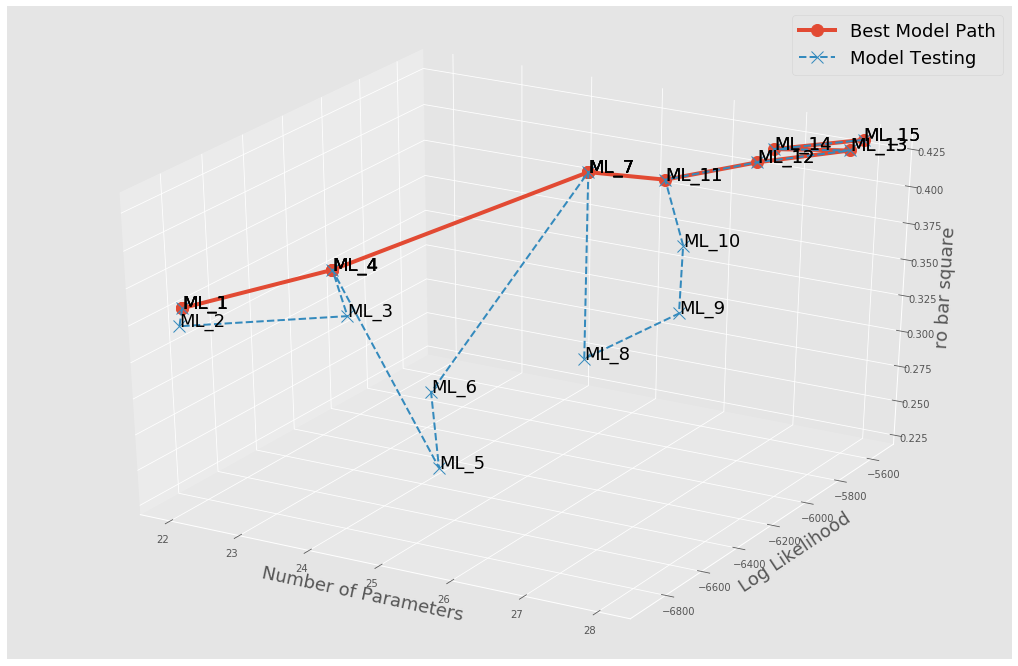

In [76]:
"""
=======================
Plot 2D data on 3D plot
=======================

Demonstrates using ax.plot's zdir keyword to plot 2D data on
selective axes of a 3D plot.
"""

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


fig = plt.figure()
ax = fig.gca(projection='3d')
font_size = 18
# Plot a sin curve using the x and y axes.
x = np.array(parN)
y = np.array(LL)
z = np.array(robar2)
label = np.array(best[1:])
ax.plot(x, y, z, zdir='z', linewidth=4, markersize=12, marker='o', label='Best Model Path')

for label, x, y, z in zip(label, x, y, z):
    ax.text(x, y, z, label, fontsize=font_size)

x = [len(results[i].data.betaNames) for i in range(len(results))]
y = np.array([results[i].data.logLike for i in range(len(results))])
z = np.array([results[i].data.rhoBarSquare for i in range(len(results))])
label = np.array(ModNameSeqence)
ax.plot(x, y, z, '--', zdir='z', linewidth=2, markersize=12, marker='x', label='Model Testing')

for label, x, y, z in zip(label, x, y, z):
    ax.text(x, y, z, label, fontsize=font_size)
# Make legend, set axes limits and labels
ax.legend(fontsize=font_size)
# Make legend, set axes limits and labels
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
#ax.set_zlim(0, 1)
ax.set_xlabel('Number of Parameters', fontsize=font_size)
ax.set_ylabel('Log Likelihood', fontsize=font_size)
ax.set_zlabel('ro bar square', fontsize=font_size)

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
#ax.view_init(elev=20., azim=-35)
plt.savefig('MLPanel.png', dpi=300)
plt.show()

In [92]:
# Function that calculates the market shares for SM for a given scaling of the cost

def scenario(HEvalue, costScale, database, pickShare,  draws=100):
    '''
    ...#costScale includes the variability of cost
    ...#HEvalue the simulations on different HE values
    ...#To test HE effect in conditions similar to Train, 
    ...#we put SM_TT_SCALED = TRAIN_TT_SCALED
    '''
    share = {'CAR': 3,'TRAIN': 1,'SM': 2}
    scale = pandas['SM_HE_SCALED'][0]/pandas['SM_HE'][0]
    
    #Utility functions
    TRAIN_SP = ASC_TRAIN                                      + \
     BETA_COST_random             * (TRAIN_COST_SCALED * costScale)**q_COST + \
     BETA_TIME_TRAIN_random_Norm       * TRAIN_TT_SCALED**q_TIME   + \
     BETA_HE_random_Norm               * (HEvalue*scale)**q_HE           + \
     B_AGE_ADULTS_TRAIN * AGE_2                     + \
     B_AGE_3_TRAIN      * AGE_3                     + \
     B_AGE_ADULTS_TRAIN * AGE_4                     + \
     B_AGE_5_TRAIN      * AGE_5                     + \
     B_LUGGAGE_TRAIN    * LUGGAGE                   + \
     B_MALE_TRAIN       * MALE                      + \
     B_GA_TRAIN         * GA                        + \
     B_BUSINESS_TRAIN   * BUSINESS                  + \
     B_PRIVATE          * PRIVATE                   + \
     B_COMMUTER         * COMMUTER
    
    '''
    SM_SP = ASC_SM                                   + \
         BETA_COST_random * (SM_COST_SCALED * costScale)**q_COST + \
         BETA_TIME_SM_random       * SM_TT_SCALED**q_TIME        + \
         BETA_HE_random_Norm            * (HEvalue*scale)**q_HE  + \
         B_AGE_ADULTS_SM * AGE_2                  + \
         B_AGE_ADULTS_SM * AGE_3                  + \
         B_AGE_4_SM      * AGE_4                  + \
         B_AGE_5_SM      * AGE_5                  + \
         B_FIRST_SM      * FIRST                  + \
         B_BUSINESS_SM   * BUSINESS               + \
         B_PRIVATE       * PRIVATE                + \
         B_COMMUTER      * COMMUTER
    '''
    V = {3: Car_SP,1: TRAIN_SP,2: SM_SP}
    av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}
    
    #Lets Look at CARs market share
    prob_SM = models.logit(V,av,share[pickShare])
    
    MCprob = MonteCarlo(prob_SM)
    
    simulate = {'Prob. SM': MCprob}
    
    biosim  = bio.BIOGEME(database,simulate,numberOfDraws=draws)
    
    biosim.modelName = f"marketShares_SM_HE_"+pickShare+"_NO_PANEL"
    
    simresults = biosim.simulate(results[-1].data.betaValues)
    
    return simresults['Prob. SM'].mean()

In [93]:
# Duplicate the database
#database_young = db.Database("young",pandas[pandas['AGE'] == 1].copy())
database_middelage = db.Database("middelage",pandas[(pandas['AGE'] == 1)|(pandas['AGE'] == 2)|(pandas['AGE'] == 3)].copy())
database_senior = db.Database("senior",pandas[(pandas['AGE'] == 4)|(pandas['AGE'] == 5)].copy())


print(f"Total number of observations: {database.getNumberOfObservations()}")
#print(f"Young                  : {database_young.getNumberOfObservations()}")
print(f"Middle age               : {database_middelage.getNumberOfObservations()}")
print(f"Senior                 : {database_senior.getNumberOfObservations()}")

scales = np.arange(0.8,1.2,0.05)
HEs = np.arange(5,45,5)

shares_mid = [scenario(hhe,s,database_middelage,'CAR') for hhe in HEs for s in scales]
shares_sen = [scenario(hhe,s,database_senior,'CAR') for hhe in HEs for s in scales]

Total number of observations: 10692
Middle age               : 7857
Senior                 : 2835


In [94]:
# Duplicate the database
#database_young = db.Database("young",pandas[pandas['AGE'] == 1].copy())
database_Commuter = db.Database("commuters",pandas[(pandas['PURPOSE'] == 1)].copy())
database_Business = db.Database("business",pandas[(pandas['PURPOSE'] == 3)].copy())
database_Others = db.Database("business",pandas[(pandas['PURPOSE'] == 2)|(pandas['PURPOSE'] == 4)].copy())


print(f"Total number of observations: {database.getNumberOfObservations()}")
#print(f"Young                  : {database_young.getNumberOfObservations()}")
print(f"Commuter               : {database_Commuter.getNumberOfObservations()}")
print(f"Business                 : {database_Business.getNumberOfObservations()}")
print(f"Others                 : {database_Others.getNumberOfObservations()}")

scales = np.arange(0.8,1.2,0.05)
HEs = np.arange(5,45,5)

shares_Commuter = [scenario(hhe,s,database_Commuter,'CAR') for hhe in HEs for s in scales]
shares_Business = [scenario(hhe,s,database_Business,'CAR') for hhe in HEs for s in scales]
shares_Others = [scenario(hhe,s,database_Others,'CAR') for hhe in HEs for s in scales]

Total number of observations: 10692
Commuter               : 1719
Business                 : 5328
Others                 : 3645


In [101]:
database_ALL = db.Database("ALL",pandas.copy())
shares_ALL = [scenario(hhe,s,database_ALL,'CAR') for hhe in HEs for s in scales]

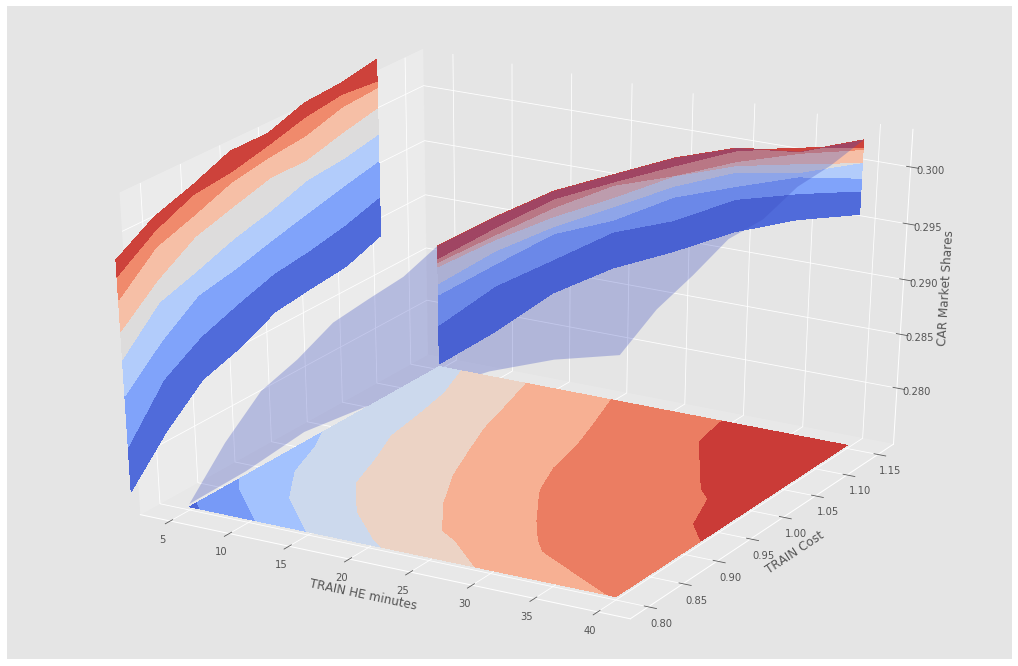

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(HEs, scales)
zC = np.array(shares_Commuter)
zB =np.array(shares_Business)
zO =np.array(shares_Others)
zAll =np.array(shares_ALL)

ZC = zC.reshape(X.shape)
ZB = zB.reshape(X.shape)
ZO = zO.reshape(X.shape)
ZAll = zAll.reshape(X.shape)


ax.plot_surface(X, Y, ZAll,cmap=cm.coolwarm, rstride=8, cstride=8, alpha=0.3, label='Commuters')
cset = ax.contourf(X, Y, ZAll, zdir='z', offset=0.275, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, ZAll, zdir='x', offset=0,cmap=cm.coolwarm)
cset = ax.contourf(X, Y, ZAll, zdir='y', offset=1.15, cmap=cm.coolwarm)

#ax.plot_surface(X, Y, ZC,cmap=cm.coolwarm, rstride=8, cstride=8, alpha=0.3, label='Commuters')
#cset = ax.contourf(X, Y, ZC, zdir='z', offset=0.24, cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, ZC, zdir='x', offset=0,cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, ZC, zdir='y', offset=1.15, cmap=cm.coolwarm)

#ax.plot_surface(X, Y, ZB, cmap=cm.coolwarm, rstride=8, cstride=8, alpha=0.3, label='Business')
#cset = ax.contourf(X, Y, ZB, zdir='z', offset=0.23, cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, ZB, zdir='x', offset=1,cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, ZB, zdir='y', offset=1.2, cmap=cm.coolwarm)

#ax.plot_surface(X, Y, ZO, cmap=cm.coolwarm, rstride=8, cstride=8, alpha=0.3, label='Others')
#cset = ax.contourf(X, Y, ZO, zdir='z', offset=0.23, cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, ZO, zdir='x', offset=1,cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, ZO, zdir='y', offset=1.2, cmap=cm.coolwarm)

ax.set_xlabel('TRAIN HE minutes')
#ax.set_xlim(0, 45)
ax.set_ylabel('TRAIN Cost')
#ax.set_ylim(0.8, 1.15)
ax.set_zlabel('CAR Market Shares')
#ax.set_zlim(0.24, 0.32)
#plt.savefig('MARKETshareCarPURPOSE-SMtrainEqualTT.png', dpi=300)
plt.show()

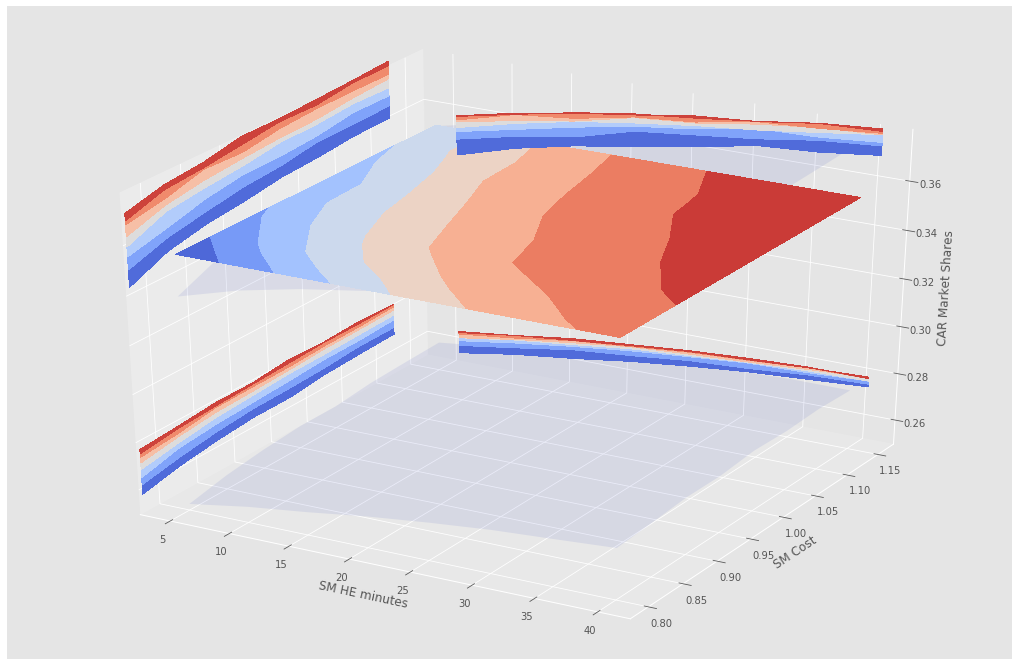

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(HEs, scales)
zm = np.array(shares_mid)
zs =np.array(shares_sen)
Zm = zm.reshape(X.shape)
Zs = zs.reshape(X.shape)

ax.plot_surface(X, Y, Zs,cmap=cm.coolwarm, rstride=8, cstride=8, alpha=0.1, label='senior')
cset = ax.contourf(X, Y, Zs, zdir='z', offset=0.355, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Zs, zdir='x', offset=1,cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Zs, zdir='y',offset= 1.18, cmap=cm.coolwarm)

ax.plot_surface(X, Y, Zm, cmap=cm.coolwarm, rstride=8, cstride=8, alpha=0.1, label='middel age and young')
cset = ax.contourf(X, Y, Zm, zdir='z', offset=0.355, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Zm, zdir='x', offset=1, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Zm, zdir='y',offset= 1.18, cmap=cm.coolwarm)

ax.set_xlabel('SM HE minutes')
ax.set_ylabel('SM Cost')
ax.set_zlabel('CAR Market Shares')
#plt.savefig('MARKETshareCarSeniorYoung-SMtrainEqualTT.png', dpi=300)
plt.show()